<a href="https://colab.research.google.com/github/vsadykov/kineticsim_reader/blob/main/ML_VDFs_modeltesting_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules and dependences

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

# Loading VDFs and augmenting them with the particle abundances

In [5]:
featurevector_allvdfs_all_4040 = np.load('allsimulations.mldata_vdfs_4040.npy')
featurevector_allvdfs_all_6060 = np.load('allsimulations.mldata_vdfs_6060.npy')
print(featurevector_allvdfs_all_4040.shape)
print(featurevector_allvdfs_all_6060.shape)

(1596, 2, 40, 40)
(1596, 2, 60, 60)


In [6]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
print(featurevector_allmoments.shape)
pops_h = featurevector_allmoments[:,18]
pops_he = featurevector_allmoments[:,19]

(1596, 20)


In [7]:
ncases = featurevector_allvdfs_all_4040.shape[0]
featurevector_allvdfs_all_4040_norm = np.copy(np.log10(featurevector_allvdfs_all_4040 + 1))
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_4040_norm[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_4040_norm[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_4040_norm[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_4040_norm[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_4040_norm[ncase,1,:,:])

ncases = featurevector_allvdfs_all_6060.shape[0]
featurevector_allvdfs_all_6060_norm = np.copy(np.log10(featurevector_allvdfs_all_6060 + 1))
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_6060_norm[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_6060_norm[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_6060_norm[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_6060_norm[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_6060_norm[ncase,1,:,:])

In [8]:
ncases = featurevector_allvdfs_all_4040_norm.shape[0]
featurevector_allvdfs_all_4040_aug = np.zeros([ncases,2*40*40+2], dtype=float)
featurevector_allvdfs_all_4040_aug[:,:-2] = np.log10(featurevector_allvdfs_all_4040_norm.reshape(featurevector_allvdfs_all_4040_norm.shape[0], -1) + 1)
featurevector_allvdfs_all_4040_aug[:,-2] = pops_h
featurevector_allvdfs_all_4040_aug[:,-1] = pops_he

ncases = featurevector_allvdfs_all_6060_norm.shape[0]
featurevector_allvdfs_all_6060_aug = np.zeros([ncases,2*60*60+2], dtype=float)
featurevector_allvdfs_all_6060_aug[:,:-2] = np.log10(featurevector_allvdfs_all_6060_norm.reshape(featurevector_allvdfs_all_6060_norm.shape[0], -1) + 1)
featurevector_allvdfs_all_6060_aug[:,-2] = pops_h
featurevector_allvdfs_all_6060_aug[:,-1] = pops_he

print(featurevector_allvdfs_all_4040_aug.shape)
print(featurevector_allvdfs_all_6060_aug.shape)

(1596, 3202)
(1596, 7202)


Loading labels for 0.001 anisotropy or magnetic energy change

In [9]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('allsimulations.timep_array_all.npy')
labels_an = np.load('allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('allsimulations.labels_allmoments_me_01_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

print(labels_allmoments.shape)

The total number of data points is: 1596
Among them unstable (positive) samples: 418
(1596,)


In [10]:
simnames = np.load('allsimulations.simnames_all.npy')

Producing 10-CV data set separations

In [11]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
data_split.split(labels_allmoments)

<generator object BaseShuffleSplit.split at 0x7a95a7adf640>

# Best architecture for 40x40 VDFs (5-fold CV for faster assessment)

In [12]:
class VDFCNN_4040_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*5*5+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 5 * 5)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*5*5+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 5 * 5)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*10*10+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 10 * 10)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*10*10+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 10 * 10)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*20*20+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 20 * 20)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*20*20+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 20 * 20)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x

In [13]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

100%|██████████| 2000/2000 [01:35<00:00, 20.99it/s]


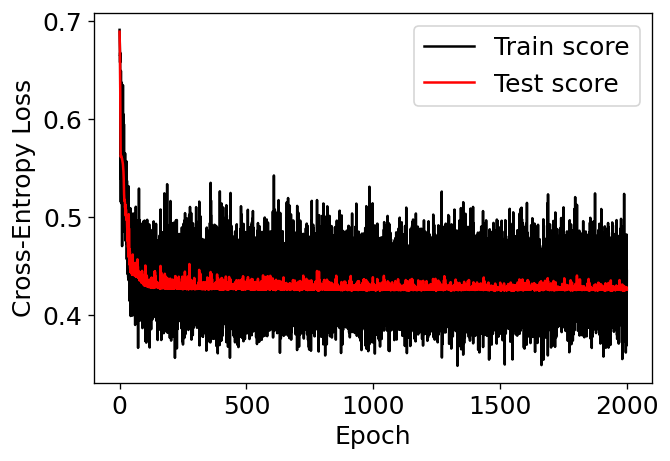

250 0.8842504743833017 0.631006450135491
500 0.888045540796964 0.6360825922674707
750 0.888045540796964 0.6360825922674707
1000 0.8861480075901328 0.6335445212014809
1250 0.8804554079696395 0.6309110339300027
1500 0.888045540796964 0.6311018663409793
1750 0.8823529411764706 0.6035647494370444
---------------------------------------------


100%|██████████| 2000/2000 [01:26<00:00, 23.15it/s]


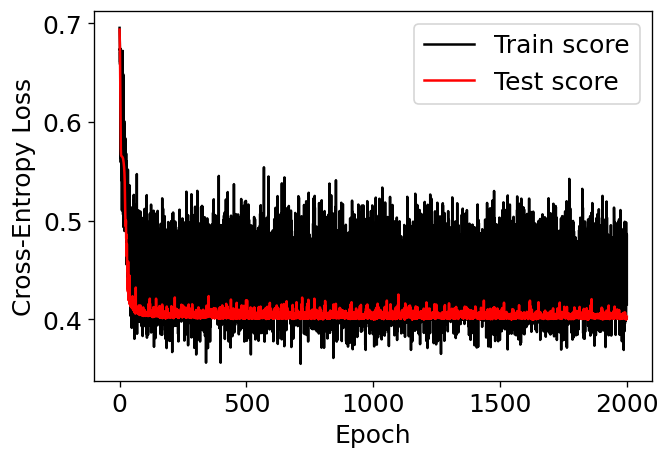

250 0.9070208728652751 0.6913476584863173
500 0.9127134724857685 0.6790389679783214
750 0.9146110056925996 0.6915384908972939
1000 0.9070208728652751 0.6913476584863173
1250 0.9108159392789373 0.6715201709858403
1500 0.9146110056925996 0.6965192168237854
1750 0.9070208728652751 0.686366932559826
---------------------------------------------


100%|██████████| 2000/2000 [01:26<00:00, 23.14it/s]


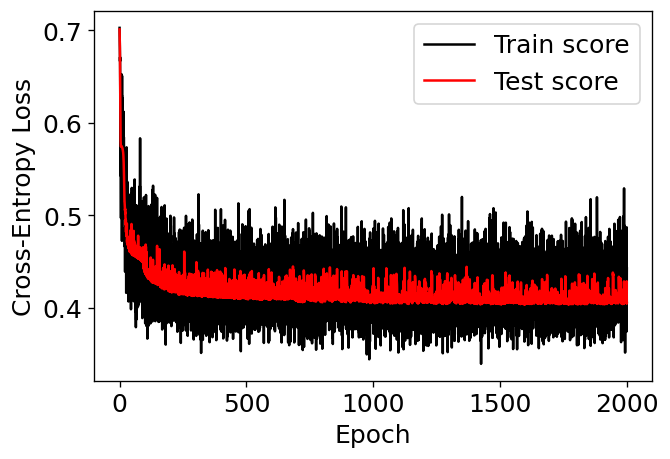

250 0.8994307400379506 0.6648742861380998
500 0.8975332068311196 0.662296966550471
750 0.8956356736242884 0.6597196469628421
1000 0.9032258064516129 0.6607950752799823
1250 0.905123339658444 0.6726062449009864
1500 0.9127134724857685 0.682915523251502
1750 0.9070208728652751 0.6613327894385522
---------------------------------------------


100%|██████████| 2000/2000 [01:28<00:00, 22.53it/s]


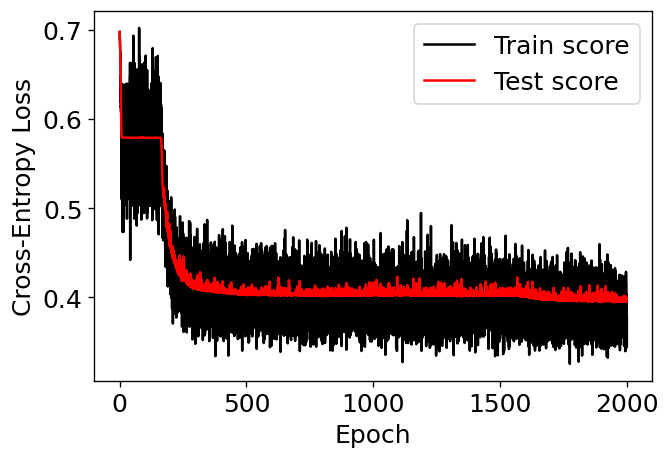

250 0.8994307400379506 0.6715762273901809
500 0.9127134724857685 0.7306939830195643
750 0.9127134724857685 0.7261351052048726
1000 0.9127134724857685 0.7306939830195643
1250 0.9146110056925996 0.7378368401624216
1500 0.9108159392789373 0.7326688815060909
1750 0.9184060721062619 0.729328165374677
---------------------------------------------


100%|██████████| 2000/2000 [01:29<00:00, 22.40it/s]


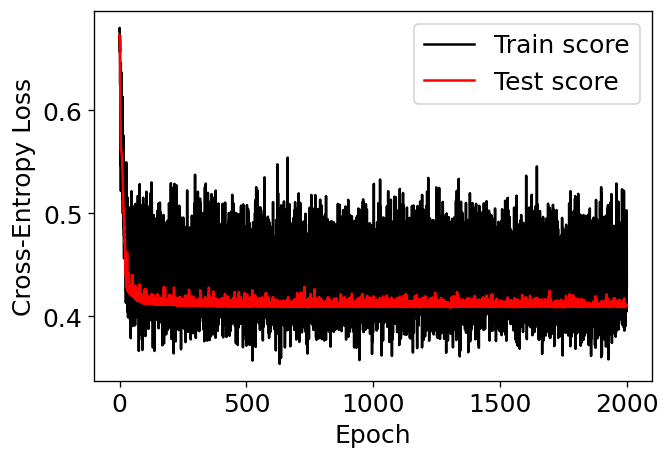

250 0.8994307400379506 0.6831681288215411
500 0.905123339658444 0.6908017166078007
750 0.8994307400379506 0.6831681288215411
1000 0.8975332068311196 0.6806235995594546
1250 0.9032258064516129 0.6735027154304812
1500 0.9032258064516129 0.6882571873457142
1750 0.8975332068311196 0.6806235995594546
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 95.4+/-2.8
TN = 377.8+/-2.227105745132009
FP = 13.4+/-3.0724582991474434
FN = 40.4+/-2.8000000000000003
Acc = 0.8979127134724857+/-0.007436781002757258
TSS = 0.668394550194326+/-0.020811002669415178
=>=>=> NUMBER OF EPOCHS: 500
TP = 96.4+/-5.885575587824865
TN = 379.6+/-5.083306010855534
FP = 11.6+/-3.6660605559646724
FN = 39.4+/-3.878143885933063
Acc = 0.9032258064516128+/-0.009449639163558803
TSS = 0.6797828452847255+/-0.0313986652360203
=>=>=> NUMBER OF EPOCHS: 750
TP = 96.6+/-5.276362383309167
TN = 378.8+/-4.707440918375927
FP = 12.4+/-3.6660605559646724
FN = 39.2+/-3.48711915483253

In [ ]:
# NETWORK: VDFCNN_4040_CNN3_CONN2
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:24<00:00, 23.76it/s]


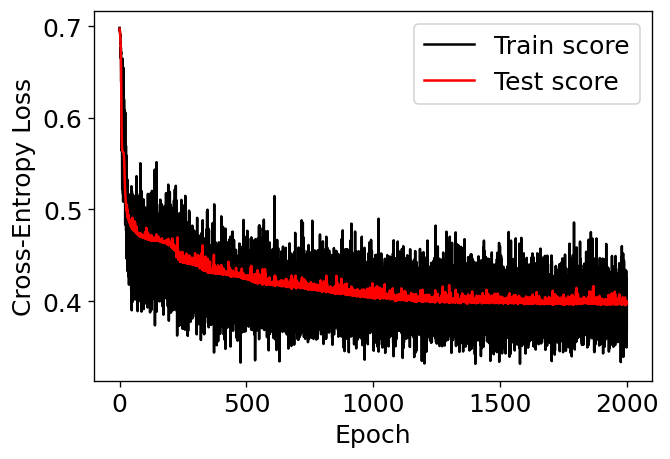

250 0.8690702087286527 0.6206633334605549
500 0.8861480075901328 0.6684096026869204
750 0.889943074003795 0.6934086485248655
1000 0.9089184060721063 0.7237700851112553
1250 0.9108159392789373 0.7362696080302278
1500 0.9127134724857685 0.728846227243235
1750 0.9089184060721063 0.7287508110377466
---------------------------------------------


100%|██████████| 2000/2000 [01:24<00:00, 23.56it/s]


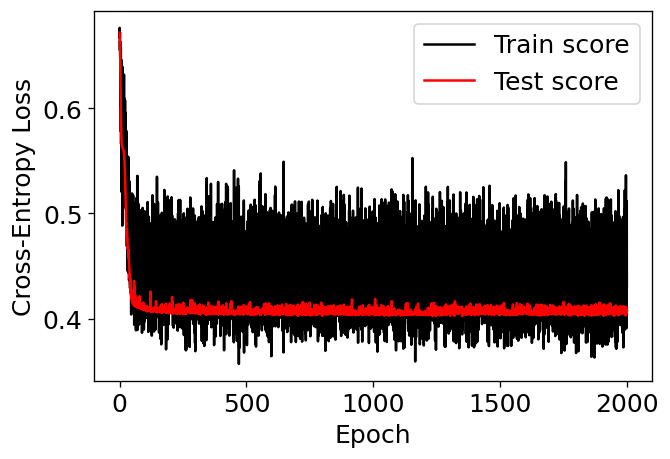

250 0.9108159392789373 0.6765008969123315
500 0.905123339658444 0.6788481355673447
750 0.8975332068311196 0.6786573031563681
1000 0.9108159392789373 0.696423800618297
1250 0.9070208728652751 0.6913476584863173
1500 0.9089184060721063 0.6938857295523071
1750 0.8994307400379506 0.6811953742223579
---------------------------------------------


100%|██████████| 2000/2000 [01:23<00:00, 23.85it/s]


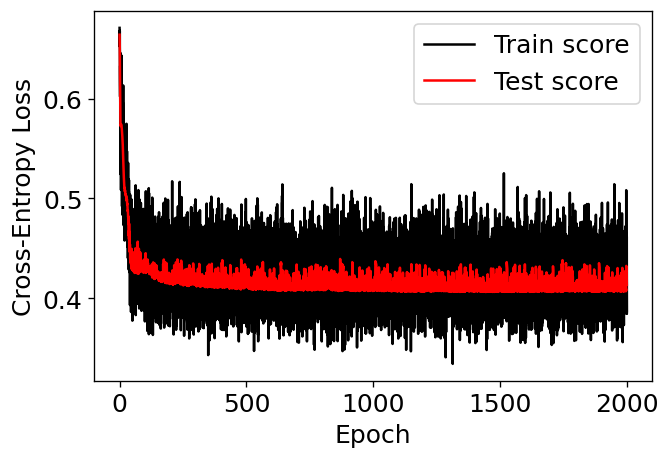

250 0.9032258064516129 0.6423273752132315
500 0.9013282732447818 0.6536008306756655
750 0.8956356736242884 0.6089334717792776
1000 0.9032258064516129 0.6746458503300452
1250 0.9070208728652751 0.6751835644886153
1500 0.905123339658444 0.6541385448342357
1750 0.9089184060721063 0.6685270340428688
---------------------------------------------


100%|██████████| 2000/2000 [01:23<00:00, 23.86it/s]


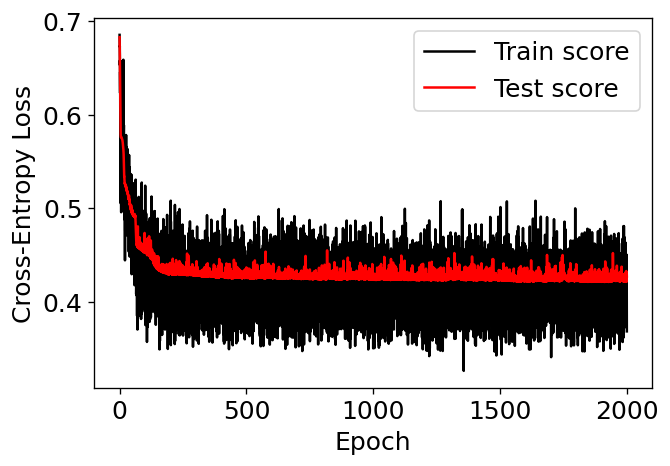

RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:29<00:00, 22.23it/s]


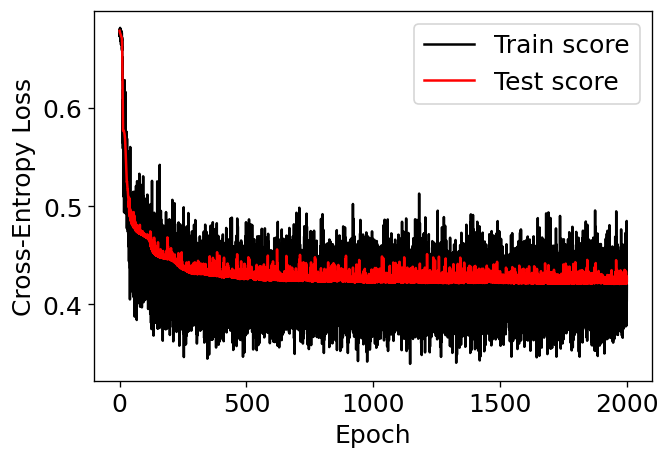

RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:26<00:00, 23.20it/s]


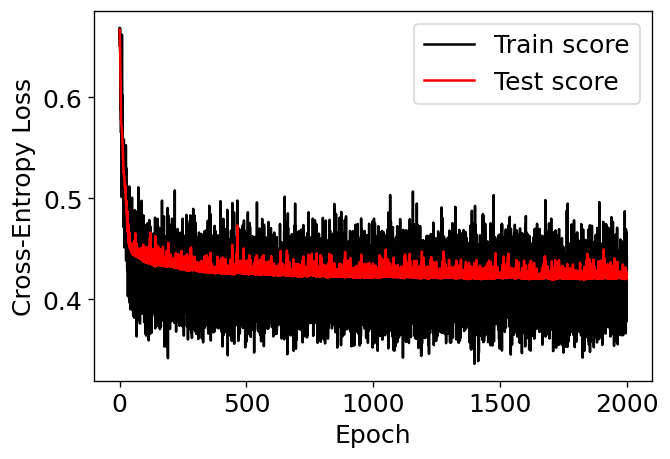

250 0.889943074003795 0.6039497969730528
500 0.888045540796964 0.5876891842008121
750 0.8918406072106262 0.6293281653746771
1000 0.8918406072106262 0.6156515319306017
1250 0.8918406072106262 0.6202104097452934
1500 0.8937381404174574 0.6182355112587671
1750 0.8918406072106262 0.61109265411591
---------------------------------------------


100%|██████████| 2000/2000 [01:24<00:00, 23.70it/s]


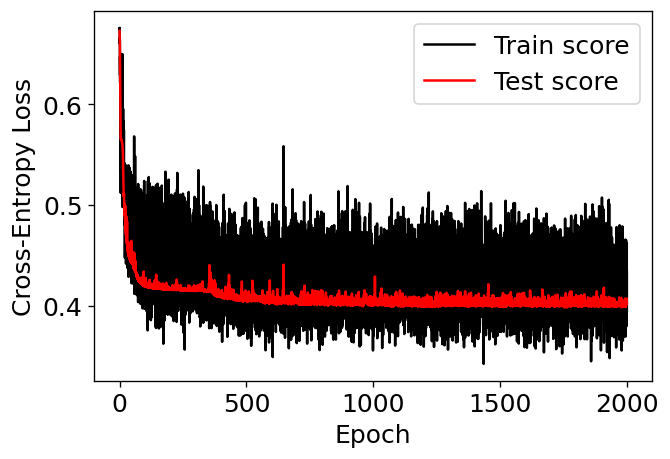

250 0.8994307400379506 0.6782499715164635
500 0.905123339658444 0.6662109300824124
750 0.9070208728652751 0.6933462458698871
1000 0.9184060721062619 0.7036952641373286
1250 0.9070208728652751 0.6540009874292659
1500 0.9032258064516129 0.6735027154304812
1750 0.9146110056925996 0.7035243629182333
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 91.2+/-3.249615361854384
TN = 380.2+/-7.858753081755401
FP = 11.0+/-9.591663046625438
FN = 44.6+/-5.9531504264548865
Acc = 0.8944971537001898+/-0.01438124882087015
TSS = 0.6443382748151268+/-0.029598017302116947
=>=>=> NUMBER OF EPOCHS: 500
TP = 91.8+/-4.707440918375928
TN = 381.0+/-5.621387729022079
FP = 10.2+/-7.493997598078078
FN = 44.0+/-7.293833011524188
Acc = 0.8971537001897533+/-0.008349146110056944
TSS = 0.6509517366426311+/-0.03263432973072846
=>=>=> NUMBER OF EPOCHS: 750
TP = 94.0+/-5.513619500836088
TN = 378.4+/-6.1838499334961226
FP = 12.8+/-8.423775875461075
FN = 41.8+/-8.2

In [ ]:
# NETWORK: VDFCNN_4040_CNN3_CONN1
ARCH = 'VDFCNN_4040_CNN3_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:19<00:00, 25.08it/s]


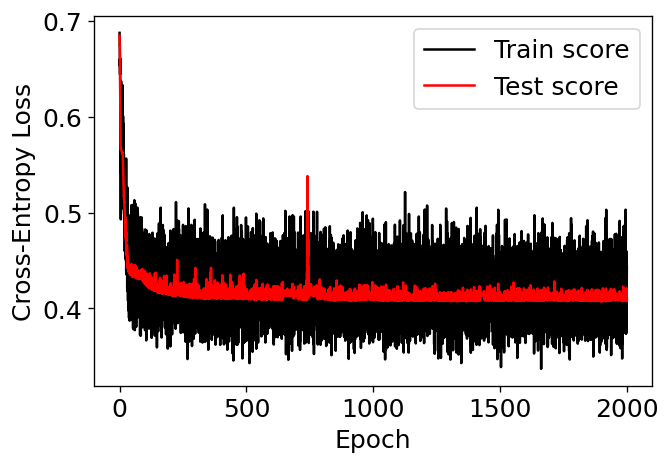

250 0.8994307400379506 0.6413495668104271
500 0.9013282732447818 0.6538490897293996
750 0.889943074003795 0.6336399374069692
1000 0.9070208728652751 0.6614633029273691
1250 0.8975332068311196 0.6537536735239113
1500 0.905123339658444 0.6489637800083966
1750 0.8956356736242884 0.6462348765314301
---------------------------------------------


100%|██████████| 2000/2000 [01:19<00:00, 25.01it/s]


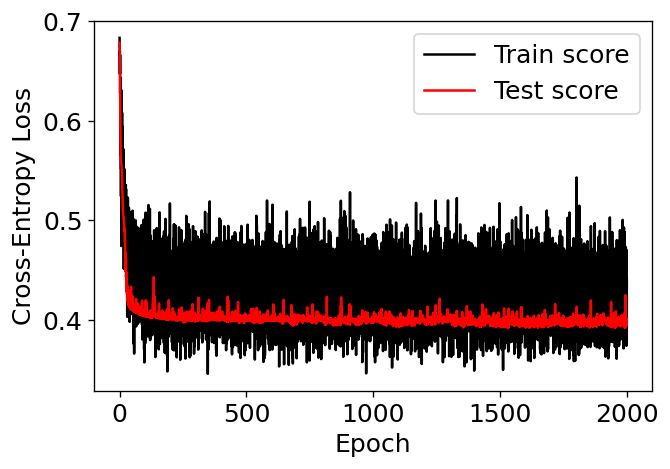

250 0.9127134724857685 0.6740582420518301
500 0.9089184060721063 0.6689820999198504
750 0.9108159392789373 0.681481622838823
1000 0.9146110056925996 0.6716155871913285
1250 0.9089184060721063 0.6938857295523071
1500 0.9127134724857685 0.6840196939048128
1750 0.9127134724857685 0.6840196939048128
---------------------------------------------


100%|██████████| 2000/2000 [01:21<00:00, 24.49it/s]


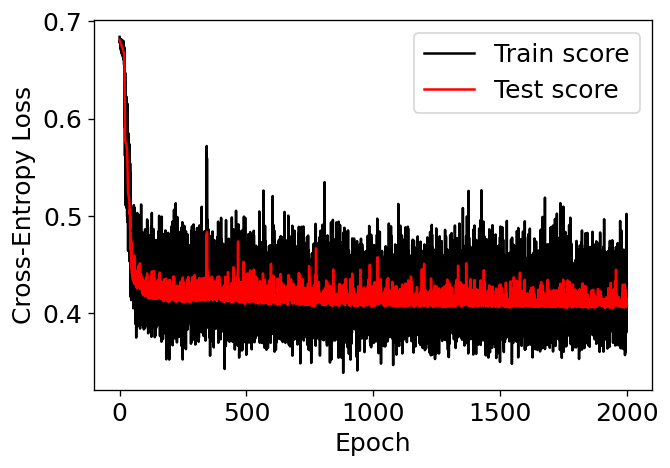

250 0.872865275142315 0.6149410368612326
500 0.9070208728652751 0.6751835644886153
750 0.8766603415559773 0.6431803011199287
1000 0.8937381404174574 0.6571423273752133
1250 0.905123339658444 0.6726062449009864
1500 0.9032258064516129 0.6607950752799823
1750 0.8975332068311196 0.6669138915671586
---------------------------------------------


100%|██████████| 2000/2000 [01:21<00:00, 24.68it/s]


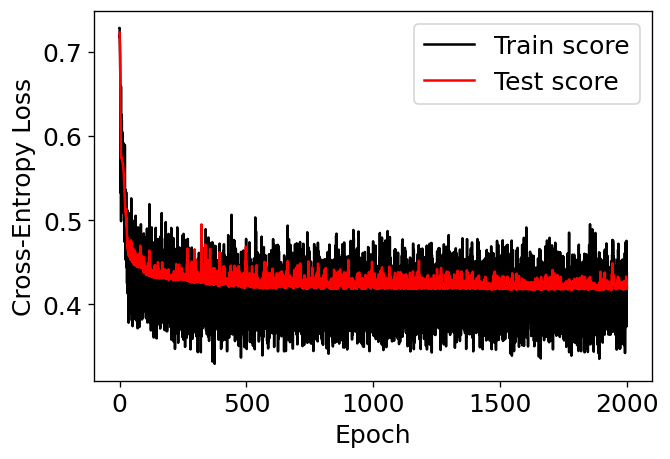

250 0.8785578747628083 0.5702104097452935
500 0.8861480075901328 0.6078995939461056
750 0.8804554079696395 0.6229420450350682
1000 0.8861480075901328 0.6261351052048727
1250 0.8861480075901328 0.639811738648948
1500 0.8994307400379506 0.6442229605020303
1750 0.8956356736242884 0.6253783684016242
---------------------------------------------


100%|██████████| 2000/2000 [01:20<00:00, 24.81it/s]


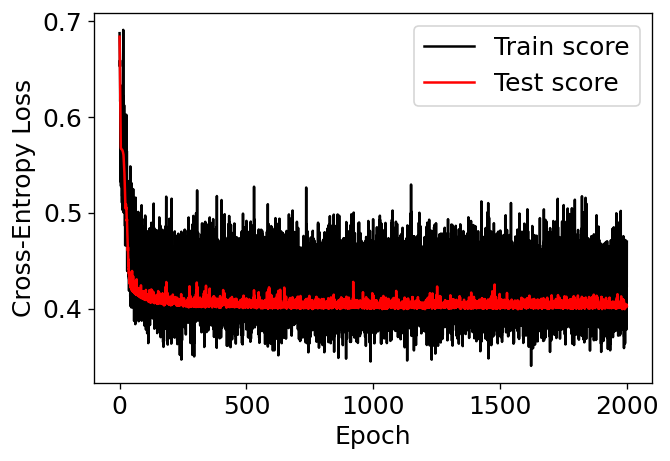

250 0.905123339658444 0.67112908738749
500 0.9032258064516129 0.6390756142949375
750 0.9108159392789373 0.6738445178686719
1000 0.9013282732447818 0.6316129277277733
1250 0.9032258064516129 0.6292392996847822
1500 0.9070208728652751 0.6540009874292659
1750 0.9108159392789373 0.6787626751737496
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 89.4+/-4.127953488110059
TN = 381.6+/-7.863841300534999
FP = 9.6+/-5.953150426454887
FN = 46.4+/-6.086049621881176
Acc = 0.8937381404174574+/-0.01541563264636804
TSS = 0.6343376685712547+/-0.03864979642709645
=>=>=> NUMBER OF EPOCHS: 500
TP = 90.4+/-3.1368774282716245
TN = 384.6+/-3.7202150475476548
FP = 6.6+/-1.7435595774162693
FN = 45.4+/-3.7202150475476548
Acc = 0.9013282732447818+/-0.008050551588461652
TSS = 0.6489979924757817+/-0.024067047292957264
=>=>=> NUMBER OF EPOCHS: 750
TP = 93.0+/-2.898275349237888
TN = 378.0+/-9.273618495495704
FP = 13.2+/-6.794115100585212
FN = 42.8+/-2.481

In [ ]:
# NETWORK: VDFCNN_4040_CNN2_CONN2
ARCH = 'VDFCNN_4040_CNN2_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:16<00:00, 26.06it/s]


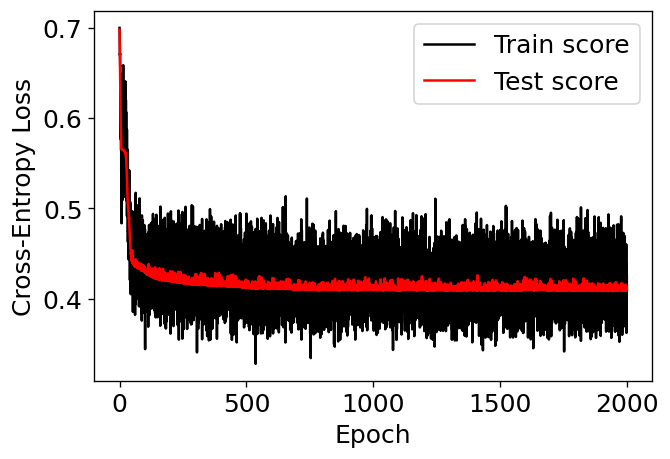

250 0.8994307400379506 0.6463302927369184
500 0.8956356736242884 0.6462348765314301
750 0.9032258064516129 0.6414449830159155
1000 0.9032258064516129 0.6414449830159155
1250 0.905123339658444 0.6589252318613793
1500 0.8975332068311196 0.6487729475974199
1750 0.8956356736242884 0.6512156024579214
---------------------------------------------


100%|██████████| 2000/2000 [01:15<00:00, 26.46it/s]


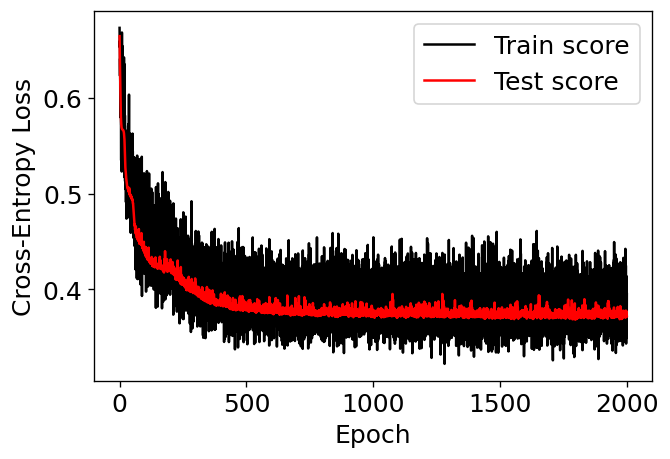

250 0.9070208728652751 0.6963283844128086
500 0.9354838709677419 0.7792259837410785
750 0.9392789373814042 0.794263577726041
1000 0.9449715370018975 0.8118392427769932
1250 0.9392789373814042 0.824147933284989
1500 0.9392789373814042 0.7743406740200756
1750 0.9392789373814042 0.7843021258730583
---------------------------------------------


100%|██████████| 2000/2000 [01:15<00:00, 26.50it/s]


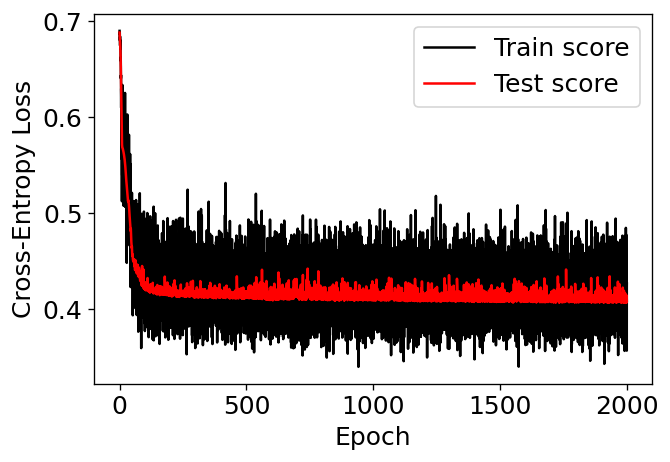

250 0.9070208728652751 0.6705666394719276
500 0.905123339658444 0.6633723948676111
750 0.9013282732447818 0.6536008306756655
1000 0.9032258064516129 0.6607950752799823
1250 0.9070208728652751 0.6613327894385522
1500 0.905123339658444 0.6633723948676111
1750 0.905123339658444 0.6633723948676111
---------------------------------------------


100%|██████████| 2000/2000 [01:15<00:00, 26.53it/s]


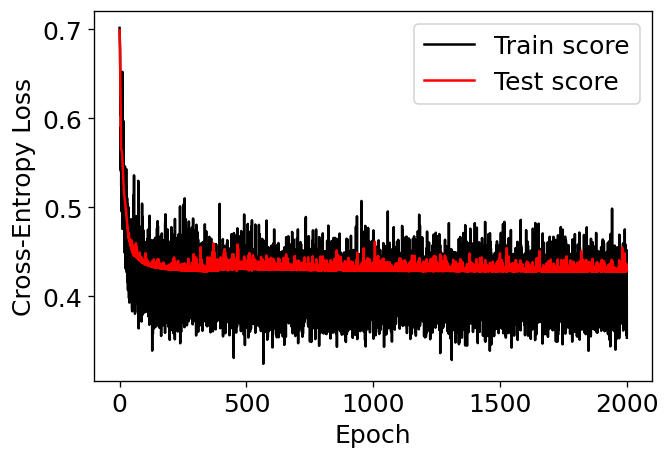

250 0.889943074003795 0.6039497969730528
500 0.8842504743833017 0.6144333702473238
750 0.888045540796964 0.6196013289036545
1000 0.888045540796964 0.6150424510889627
1250 0.8823529411764706 0.598172757475083
1500 0.8671726755218216 0.6048541897379106
1750 0.888045540796964 0.6332779623477298
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.04it/s]


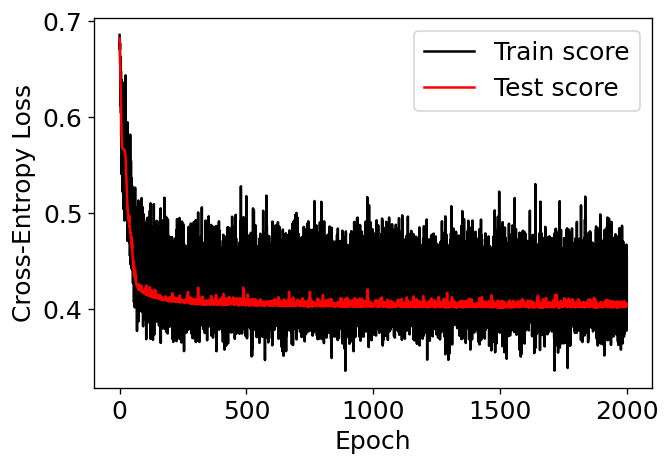

250 0.9070208728652751 0.6687554593444989
500 0.8994307400379506 0.6536591849910751
750 0.9070208728652751 0.6540009874292659
1000 0.9108159392789373 0.6689263605635942
1250 0.9146110056925996 0.6838517336979226
1500 0.9108159392789373 0.6689263605635942
1750 0.9146110056925996 0.6838517336979226
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 91.8+/-3.9698866482558417
TN = 383.6+/-1.7435595774162693
FP = 7.6+/-3.2
FN = 44.0+/-5.796550698475776
Acc = 0.9020872865275142+/-0.006746257622250924
TSS = 0.6571861145878413+/-0.030974053181862436
=>=>=> NUMBER OF EPOCHS: 500
TP = 94.2+/-6.079473661428265
TN = 382.2+/-3.54400902933387
FP = 9.0+/-2.6076809620810595
FN = 41.6+/-7.735631842325486
Acc = 0.9039848197343453+/-0.01716612201578539
TSS = 0.6713851620757038+/-0.05636328765219548
=>=>=> NUMBER OF EPOCHS: 750
TP = 93.4+/-7.552483035399682
TN = 385.0+/-4.33589667773576
FP = 6.2+/-1.7204650534085253
FN = 42.4+/-8.867919710958146
A

In [ ]:
# NETWORK: VDFCNN_4040_CNN2_CONN1
ARCH = 'VDFCNN_4040_CNN2_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:11<00:00, 28.15it/s]


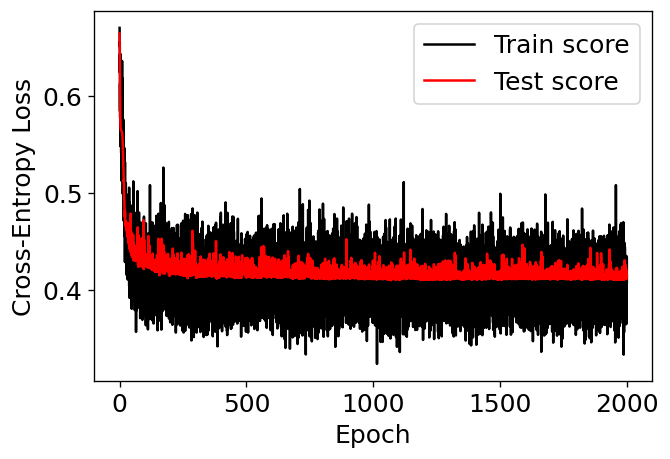

250 0.8975332068311196 0.6487729475974199
500 0.8956356736242884 0.6761192320903782
750 0.905123339658444 0.6788481355673447
1000 0.8975332068311196 0.6786573031563681
1250 0.905123339658444 0.6838288614938361
1500 0.9032258064516129 0.6713293385748635
1750 0.8994307400379506 0.6811953742223579
---------------------------------------------


100%|██████████| 2000/2000 [01:10<00:00, 28.37it/s]


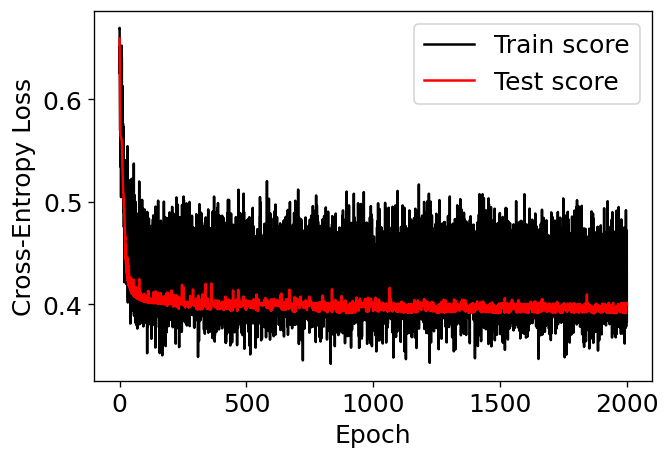

250 0.9146110056925996 0.6965192168237854
500 0.9127134724857685 0.6740582420518301
750 0.9146110056925996 0.6965192168237854
1000 0.9259962049335864 0.7167283691462157
1250 0.9146110056925996 0.6915384908972939
1500 0.9259962049335864 0.7117476432197245
1750 0.9222011385199241 0.7016907751612533
---------------------------------------------


100%|██████████| 2000/2000 [01:10<00:00, 28.56it/s]


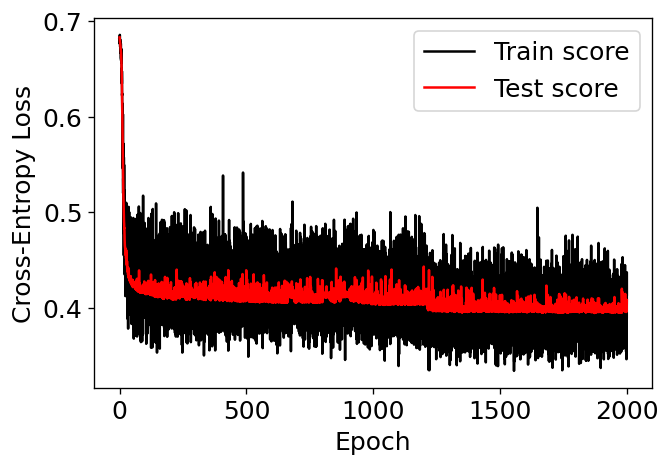

250 0.8975332068311196 0.6345954164503449
500 0.8785578747628083 0.6365237706741823
750 0.9089184060721063 0.6639101090261811
1000 0.9127134724857685 0.6875324482681896
1250 0.9165085388994307 0.697304012460135
1500 0.920303605313093 0.7116925016687681
1750 0.9184060721062619 0.7229659571312022
---------------------------------------------


100%|██████████| 2000/2000 [01:10<00:00, 28.30it/s]


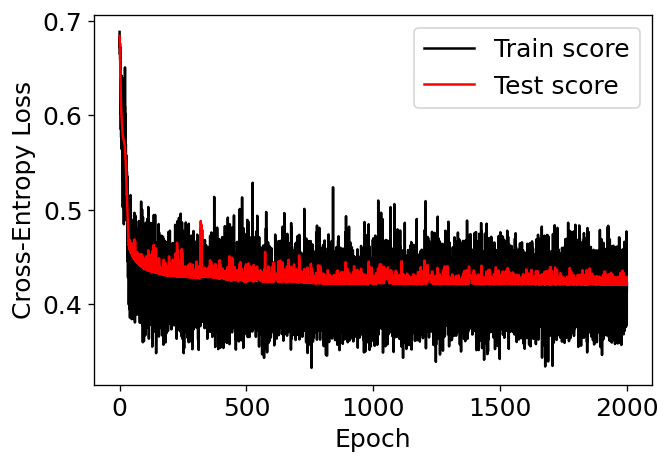

250 0.8785578747628083 0.6112403100775194
500 0.8823529411764706 0.6164082687338501
750 0.8937381404174574 0.6182355112587671
1000 0.8956356736242884 0.6253783684016242
1250 0.888045540796964 0.5968069398301956
1500 0.8918406072106262 0.6247692875599853
1750 0.8937381404174574 0.6227943890734589
---------------------------------------------


100%|██████████| 2000/2000 [01:09<00:00, 28.61it/s]


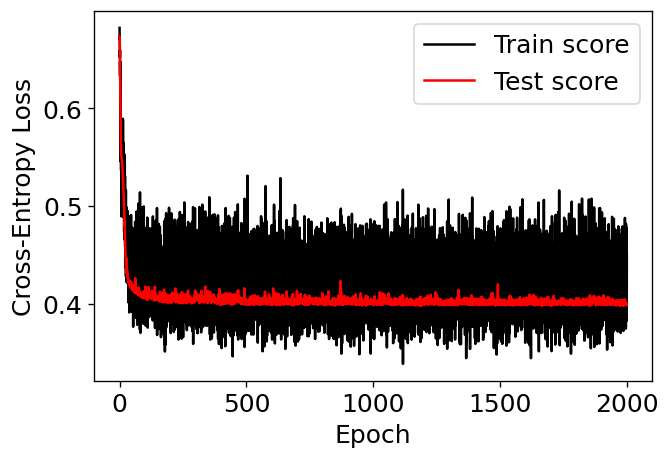

250 0.9032258064516129 0.6685845581254035
500 0.9127134724857685 0.6862253617409138
750 0.9070208728652751 0.6785917739546542
1000 0.9127134724857685 0.6862253617409138
1250 0.9127134724857685 0.6813072044358361
1500 0.9146110056925996 0.6838517336979226
1750 0.9108159392789373 0.6689263605635942
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 91.8+/-1.9390719429665317
TN = 381.6+/-5.043808085167397
FP = 9.6+/-3.4409301068170506
FN = 44.0+/-4.381780460041329
Acc = 0.8982922201138519+/-0.01167252865216674
TSS = 0.6519424898148947+/-0.02909184564799502
=>=>=> NUMBER OF EPOCHS: 500
TP = 93.6+/-2.244994432064365
TN = 378.8+/-8.518215775618742
FP = 12.4+/-6.590902821313633
FN = 42.2+/-3.9698866482558417
Acc = 0.896394686907021+/-0.014481050495892926
TSS = 0.6578669750582309+/-0.026735208292963303
=>=>=> NUMBER OF EPOCHS: 750
TP = 92.8+/-2.4819347291981715
TN = 384.6+/-1.624807680927192
FP = 6.6+/-3.2619012860600183
FN = 43.0+/-5.

In [ ]:
# NETWORK: VDFCNN_4040_CNN1_CONN2
ARCH = 'VDFCNN_4040_CNN1_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:09<00:00, 28.91it/s]


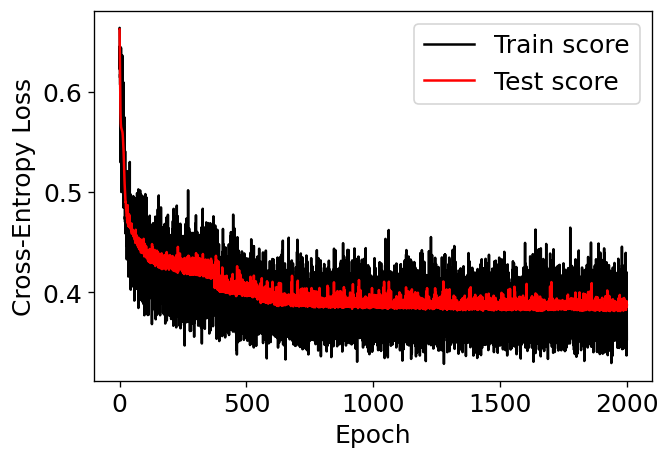

250 0.8956356736242884 0.6561963283844128
500 0.9278937381404174 0.739189343918171
750 0.9278937381404174 0.7491507957711537
1000 0.9259962049335864 0.7565741765581466
1250 0.9316888045540797 0.7592076638296248
1500 0.9240986717267552 0.7490553795656655
1750 0.9335863377609108 0.7667264608221059
---------------------------------------------


100%|██████████| 2000/2000 [01:05<00:00, 30.45it/s]


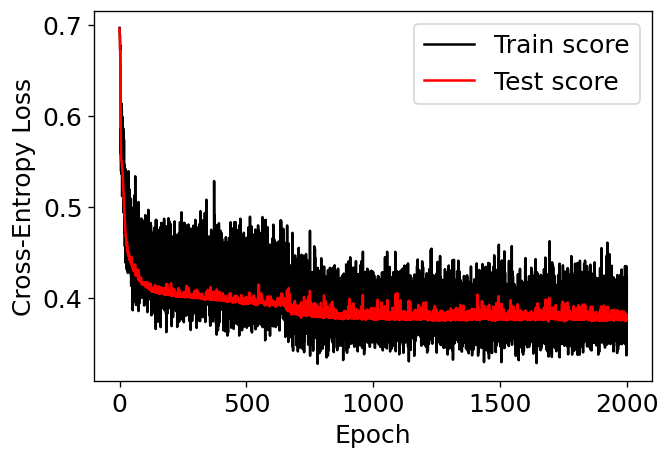

250 0.9127134724857685 0.7089233235372695
500 0.9222011385199241 0.7016907751612533
750 0.9297912713472486 0.7616503186901263
1000 0.9297912713472486 0.7666310446166177
1250 0.9430740037950665 0.7794168161520553
1500 0.9297912713472486 0.7815732223960917
1750 0.937381404174573 0.7867447807335598
---------------------------------------------


100%|██████████| 2000/2000 [01:06<00:00, 30.24it/s]


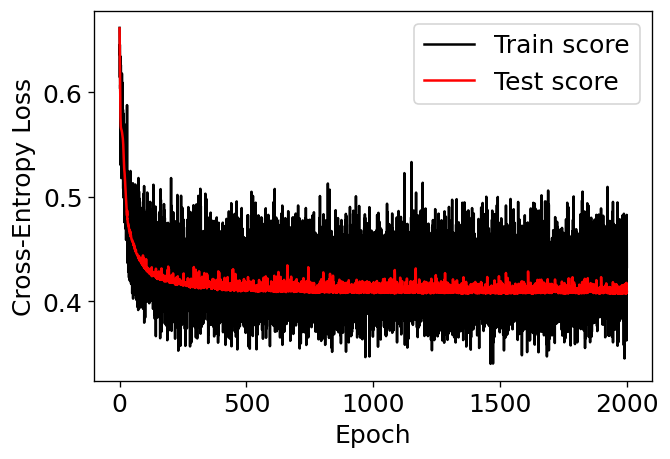

250 0.9032258064516129 0.6700289253133576
500 0.905123339658444 0.6633723948676111
750 0.9089184060721063 0.6639101090261811
1000 0.905123339658444 0.6726062449009864
1250 0.905123339658444 0.6726062449009864
1500 0.9127134724857685 0.6921493732848772
1750 0.905123339658444 0.6726062449009864
---------------------------------------------


100%|██████████| 2000/2000 [01:05<00:00, 30.72it/s]


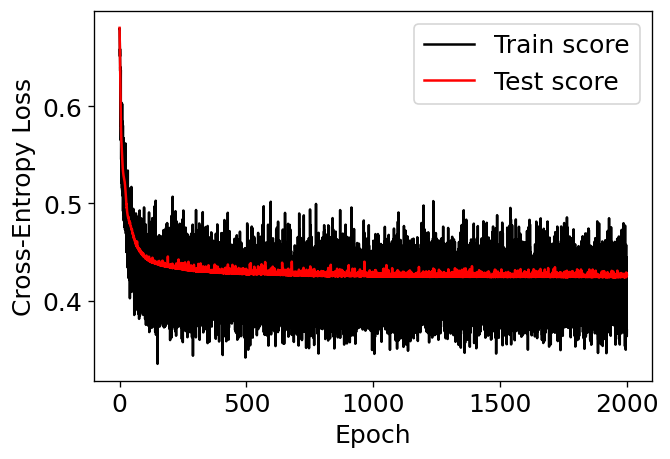

250 0.8804554079696395 0.6138242894056848
500 0.888045540796964 0.6150424510889627
750 0.8975332068311196 0.6325212255444814
1000 0.8975332068311196 0.6325212255444814
1250 0.8937381404174574 0.6273532668881506
1500 0.8937381404174574 0.6227943890734589
1750 0.8975332068311196 0.6370801033591732
---------------------------------------------


100%|██████████| 2000/2000 [01:05<00:00, 30.61it/s]


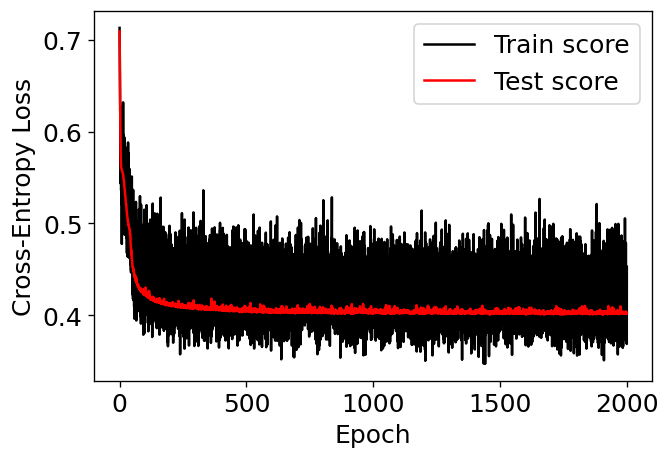

250 0.905123339658444 0.6662109300824124
500 0.9146110056925996 0.6838517336979226
750 0.9032258064516129 0.6390756142949375
1000 0.905123339658444 0.6760472446925677
1250 0.9070208728652751 0.6785917739546542
1500 0.9108159392789373 0.6689263605635942
1750 0.9127134724857685 0.6763890471307584
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 93.8+/-2.7129319932501073
TN = 380.2+/-4.069397989875161
FP = 11.0+/-2.6832815729997477
FN = 42.0+/-4.47213595499958
Acc = 0.8994307400379506+/-0.010933480296689125
TSS = 0.6630367593446274+/-0.03044076612513271
=>=>=> NUMBER OF EPOCHS: 500
TP = 94.0+/-3.521363372331802
TN = 386.4+/-4.715930449020639
FP = 4.8+/-1.9390719429665317
FN = 41.8+/-6.013318551349164
Acc = 0.91157495256167+/-0.014026351888103463
TSS = 0.6806293397467842+/-0.04118903757900474
=>=>=> NUMBER OF EPOCHS: 750
TP = 95.2+/-6.675327707311455
TN = 386.2+/-1.9390719429665317
FP = 5.0+/-2.1908902300206643
FN = 40.6+/-8.7772

In [ ]:
# NETWORK: VDFCNN_4040_CNN1_CONN1
ARCH = 'VDFCNN_4040_CNN1_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

## Best Network Architecture

CONCLUSION:

Best network configuration: VDFCNN_4040_CNN1_CONN1 with 1750 epochs

Running for the best configuration now...

100%|██████████| 1750/1750 [01:10<00:00, 24.70it/s]


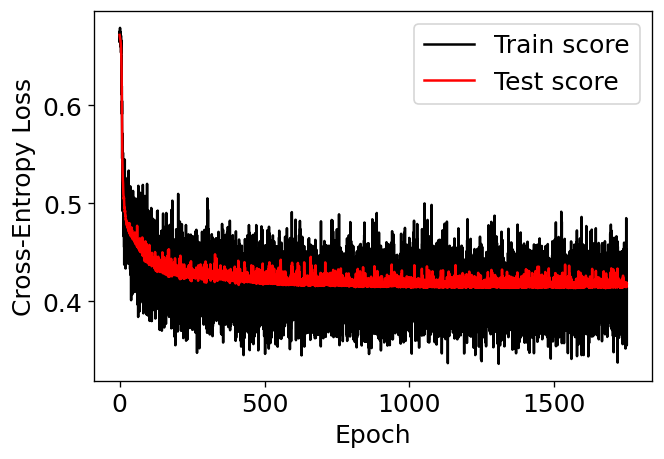

0.8994307400379506 -1
0.8994307400379506 0.6712339223693752
---------------------------------------------


100%|██████████| 1750/1750 [00:58<00:00, 30.14it/s]


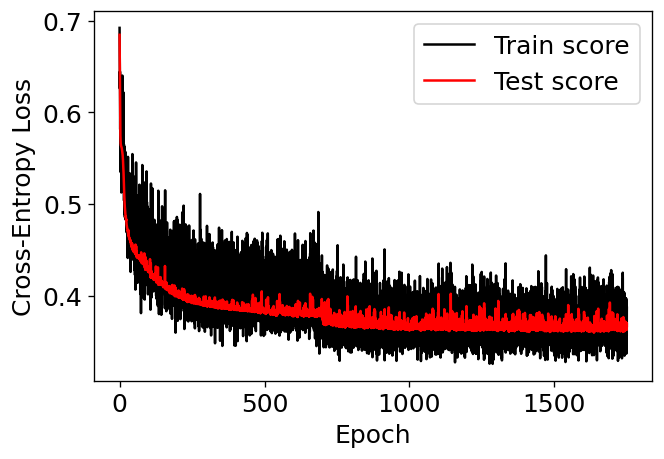

0.9506641366223909 -1
0.9506641366223909 0.864279989313385
---------------------------------------------


100%|██████████| 1750/1750 [00:58<00:00, 29.71it/s]


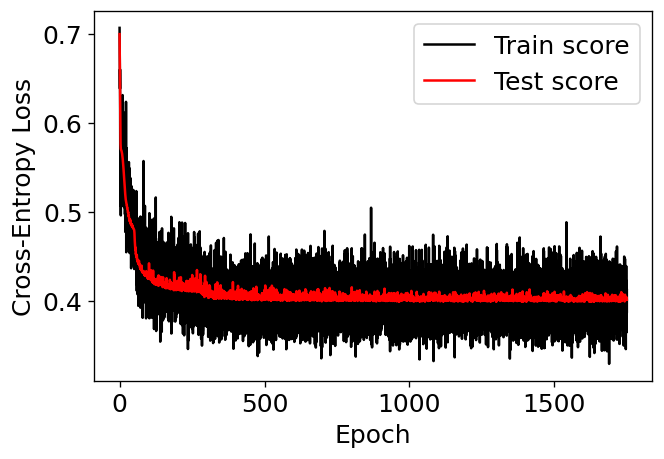

0.9240986717267552 -1
0.9240986717267552 0.7260809908774012
---------------------------------------------


100%|██████████| 1750/1750 [01:07<00:00, 25.99it/s]


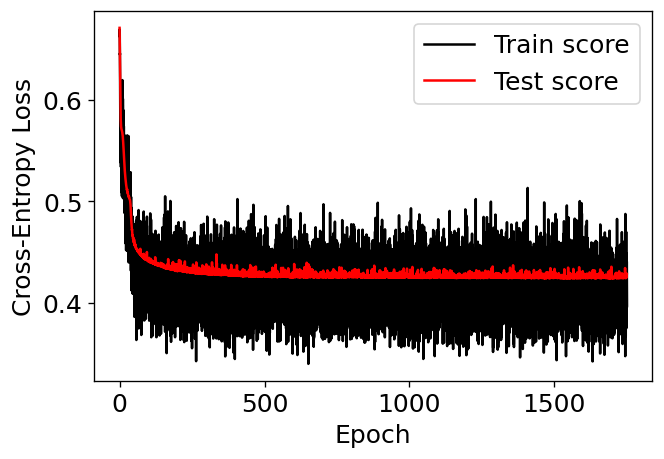

0.888045540796964 -1
0.888045540796964 0.6150424510889627
---------------------------------------------


100%|██████████| 1750/1750 [01:18<00:00, 22.27it/s]


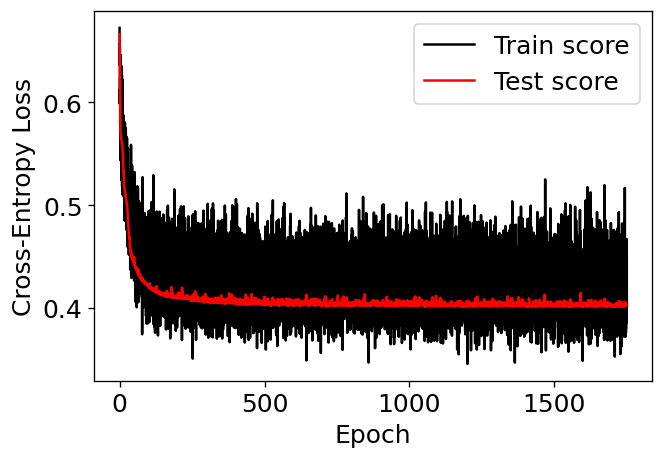

0.9146110056925996 -1
0.9146110056925996 0.6838517336979226
---------------------------------------------


100%|██████████| 1750/1750 [01:01<00:00, 28.60it/s]


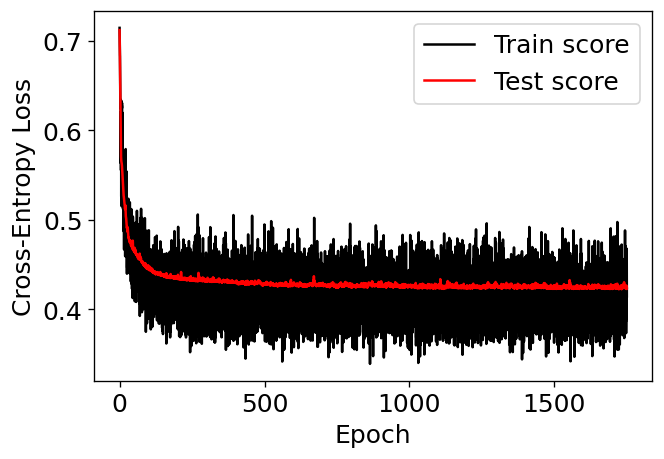

0.8937381404174574 -1
0.8937381404174574 0.6063561521916487
---------------------------------------------


100%|██████████| 1750/1750 [01:19<00:00, 21.91it/s]


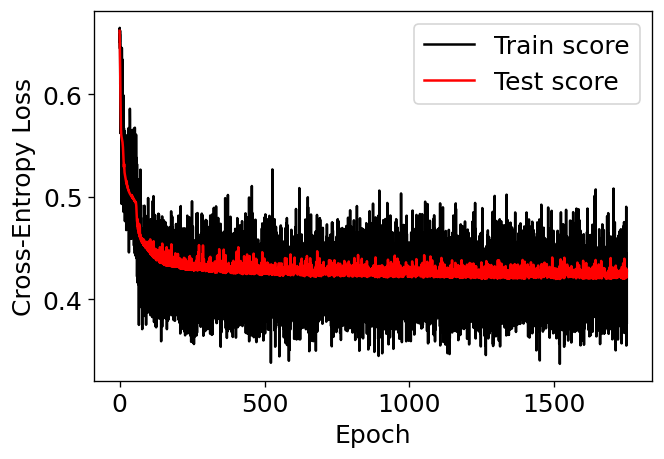

0.889943074003795 -1
0.889943074003795 0.6055803138926564
---------------------------------------------


100%|██████████| 1750/1750 [01:01<00:00, 28.67it/s]


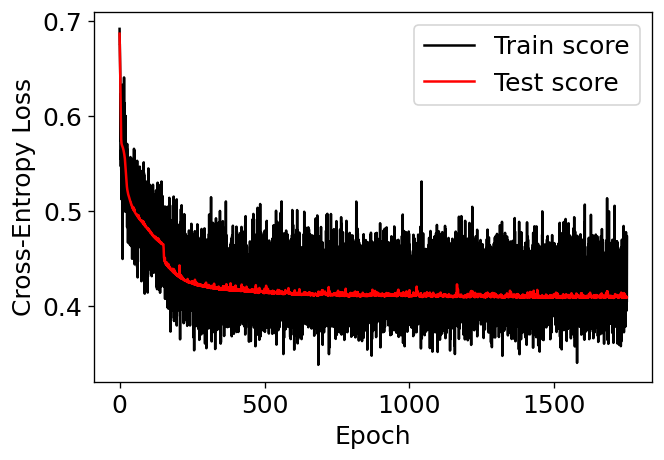

0.905123339658444 -1
0.905123339658444 0.6633723948676111
---------------------------------------------


100%|██████████| 1750/1750 [00:59<00:00, 29.46it/s]


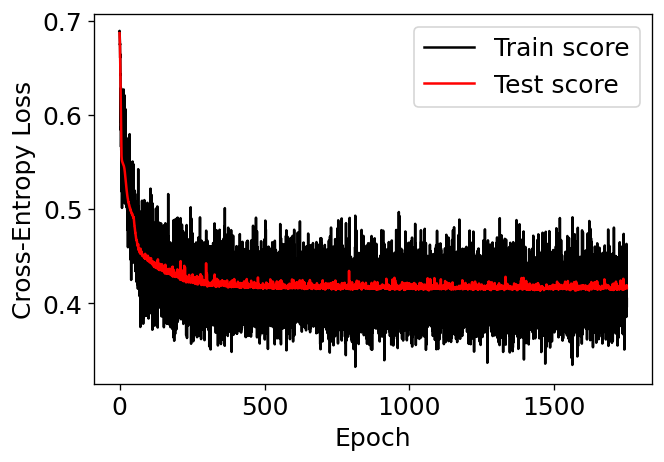

0.9032258064516129 -1
0.9032258064516129 0.6151299131315492
---------------------------------------------


100%|██████████| 1750/1750 [01:00<00:00, 29.12it/s]


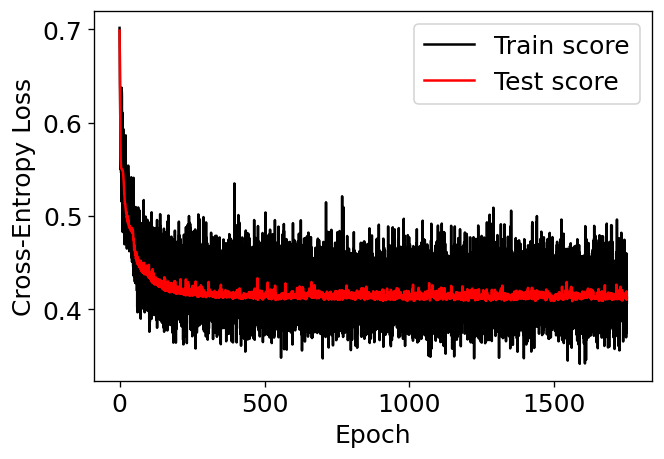

0.9089184060721063 -1
0.9089184060721063 0.6381692913385827
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN1
TP = 92.0+/-11.135528725660043
TN = 386.4+/-5.834380858325929
FP = 6.3+/-4.172529209005013
FN = 42.3+/-10.705606008068857
Acc = 0.9077798861480074+/-0.017763992012855334
TSS = 0.6689097152769097+/-0.07507323808750922


In [14]:
# NETWORK: VDFCNN_4040_CNN1_CONN1
ARCH = 'VDFCNN_4040_CNN1_CONN1'

tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1750
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Best architecture for 60x60 VDFs (5-fold CV for faster assessment)

In [15]:
class VDFCNN_6060_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*7*7+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 7 * 7)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*7*7+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 7 * 7)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*15*15+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 15 * 15)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*15*15+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 15 * 15)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*30*30+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 30 * 30)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*30*30+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 30 * 30)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x

100%|██████████| 2000/2000 [02:13<00:00, 14.95it/s]


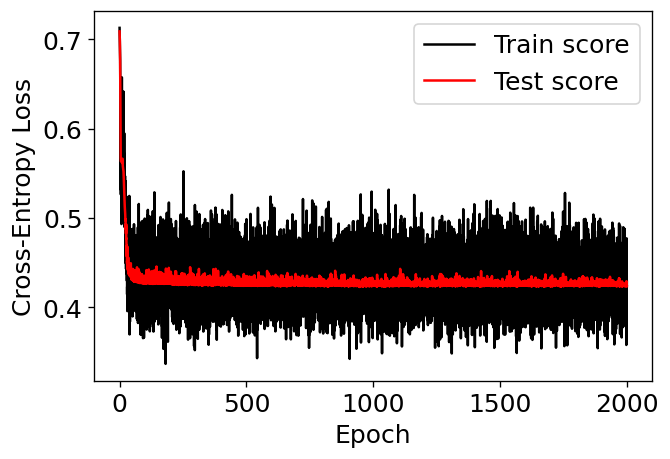

250 0.8918406072106262 0.6411587343994504
500 0.8861480075901328 0.6335445212014809
750 0.888045540796964 0.6360825922674707
1000 0.8842504743833017 0.631006450135491
1250 0.8823529411764706 0.6334491049959925
1500 0.889943074003795 0.6386206633334606
1750 0.889943074003795 0.6336399374069692
---------------------------------------------


100%|██████████| 2000/2000 [02:13<00:00, 14.96it/s]


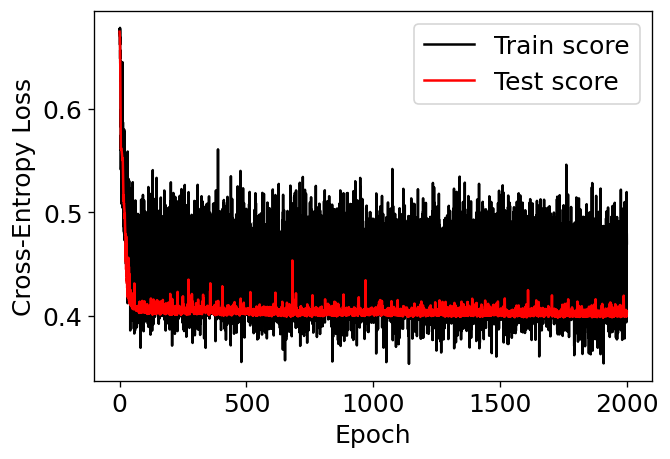

250 0.9108159392789373 0.6715201709858403
500 0.905123339658444 0.6788481355673447
750 0.9146110056925996 0.6965192168237854
1000 0.9127134724857685 0.6890004198313041
1250 0.9146110056925996 0.6965192168237854
1500 0.9127134724857685 0.6939811457577956
1750 0.9165085388994307 0.6990572878897752
---------------------------------------------


100%|██████████| 2000/2000 [02:13<00:00, 14.94it/s]


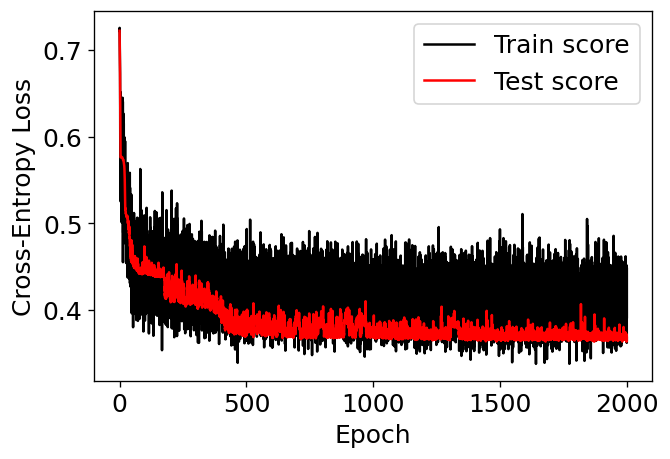

250 0.8975332068311196 0.6946154416672847
500 0.9089184060721063 0.7931840094934361
750 0.9430740037950665 0.8303419120373804
1000 0.9449715370018975 0.8329192316250092
1250 0.9468690702087287 0.8447304012460135
1500 0.9506641366223909 0.8545019654379589
1750 0.9430740037950665 0.821108062004005
---------------------------------------------


100%|██████████| 2000/2000 [02:13<00:00, 14.95it/s]


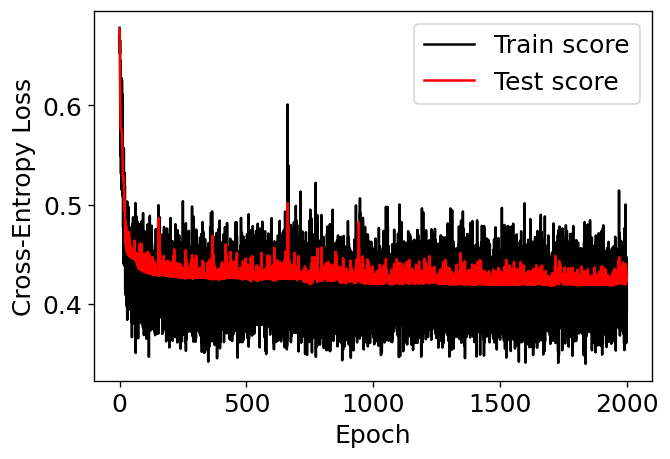

250 0.8842504743833017 0.6189922480620156
500 0.8804554079696395 0.5864710225175341
750 0.8956356736242884 0.6299372462163161
1000 0.8937381404174574 0.6319121447028424
1250 0.8918406072106262 0.6293281653746771
1500 0.8918406072106262 0.6247692875599853
1750 0.888045540796964 0.6150424510889627
---------------------------------------------


100%|██████████| 2000/2000 [02:14<00:00, 14.91it/s]


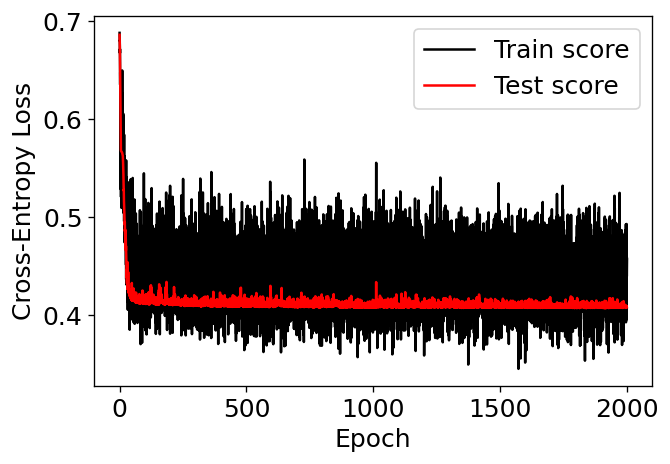

250 0.9013282732447818 0.6857126580836277
500 0.9089184060721063 0.6958907751319737
750 0.8975332068311196 0.6806235995594546
1000 0.9032258064516129 0.6882571873457142
1250 0.9032258064516129 0.6735027154304812
1500 0.9070208728652751 0.6933462458698871
1750 0.8994307400379506 0.6831681288215411
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 94.4+/-4.963869458396343
TN = 378.4+/-6.2801273872430325
FP = 12.8+/-4.354308211415448
FN = 41.4+/-4.673328578219168
Acc = 0.8971537001897534+/-0.008932525461813888
TSS = 0.6623998506396437+/-0.028283976099779392
=>=>=> NUMBER OF EPOCHS: 500
TP = 97.4+/-12.467557900406959
TN = 375.8+/-9.152048950918042
FP = 15.4+/-7.863841300534999
FN = 38.4+/-11.959933110180843
Acc = 0.8979127134724857+/-0.012144212523719172
TSS = 0.6775876927823539+/-0.06919703539853445
=>=>=> NUMBER OF EPOCHS: 750
TP = 98.2+/-10.759182125050213
TN = 380.2+/-3.9191835884530843
FP = 11.0+/-4.774934554525329
FN = 37.6+

In [ ]:
# NETWORK: VDFCNN_6060_CNN3_CONN2
ARCH = 'VDFCNN_6060_CNN3_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:08<00:00, 15.53it/s]


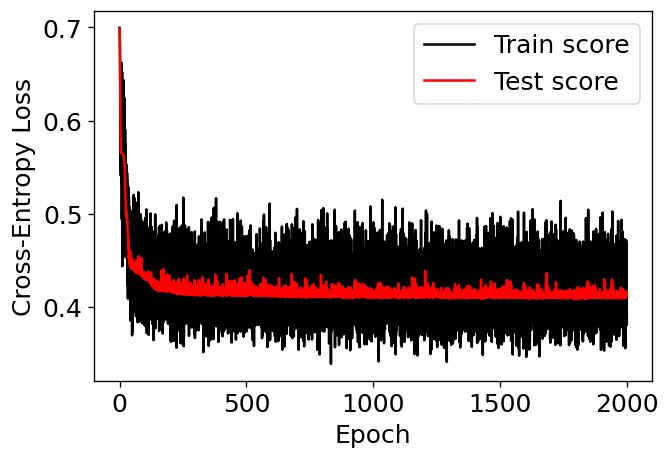

250 0.8975332068311196 0.633830769817946
500 0.8956356736242884 0.6462348765314301
750 0.905123339658444 0.653944505934888
1000 0.905123339658444 0.6589252318613793
1250 0.8994307400379506 0.6463302927369184
1500 0.9032258064516129 0.6514064348688982
1750 0.9032258064516129 0.6414449830159155
---------------------------------------------


100%|██████████| 2000/2000 [02:11<00:00, 15.25it/s]


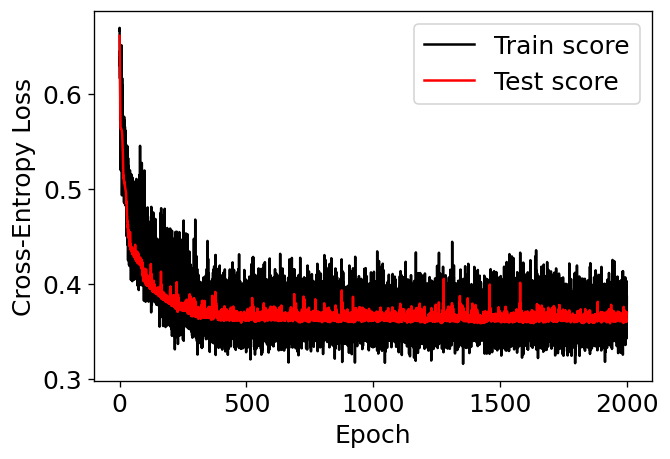

250 0.9449715370018975 0.8118392427769932
500 0.9506641366223909 0.8244341819014541
750 0.9506641366223909 0.8294149078279455
1000 0.9468690702087287 0.8492423953284226
1250 0.9563567362428842 0.8569520247318804
1500 0.9506641366223909 0.8393763596809282
1750 0.9449715370018975 0.821800694629976
---------------------------------------------


100%|██████████| 2000/2000 [02:10<00:00, 15.35it/s]


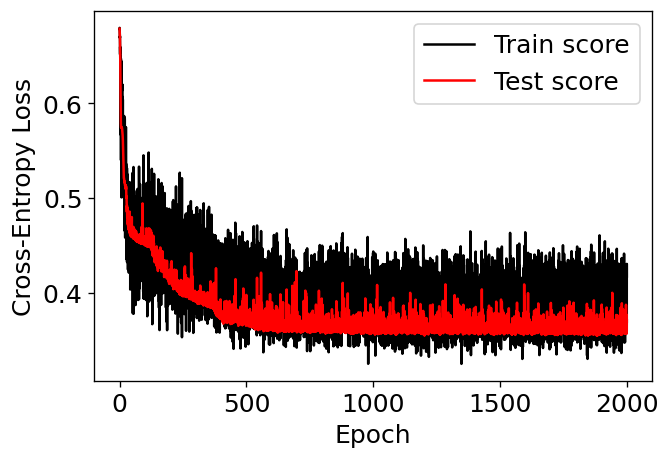

250 0.9278937381404174 0.7866387302529111
500 0.9259962049335864 0.830230660832159
750 0.9563567362428842 0.8807016242675962
1000 0.9430740037950665 0.8441926870874434
1250 0.9487666034155597 0.8473077208336424
1500 0.9639468690702088 0.9048616776681747
1750 0.9601518026565465 0.8904731884595416
---------------------------------------------


100%|██████████| 2000/2000 [02:15<00:00, 14.71it/s]


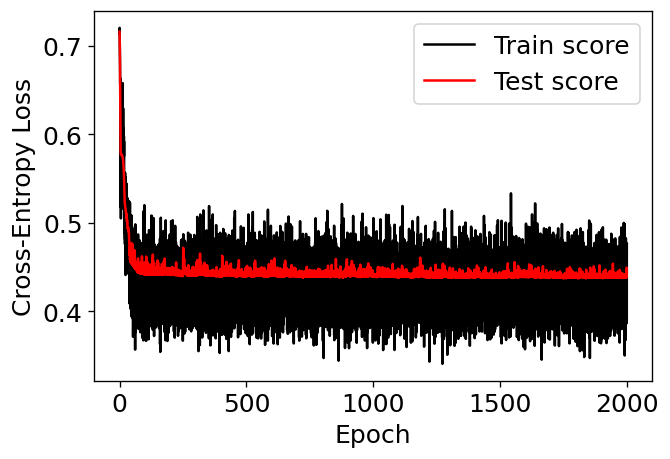

RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [02:14<00:00, 14.84it/s]


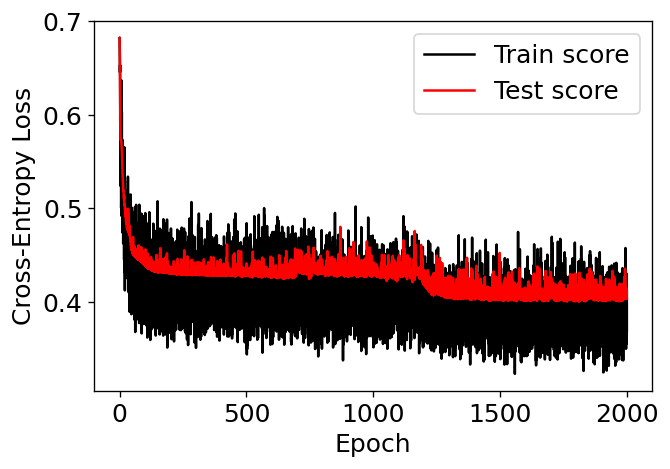

250 0.888045540796964 0.6150424510889627
500 0.8709677419354839 0.6009043927648579
750 0.8804554079696395 0.609265411590993
1000 0.8842504743833017 0.6326688815060908
1250 0.857685009487666 0.587375415282392
1500 0.8918406072106262 0.6840346991509783
1750 0.9127134724857685 0.7306939830195643
---------------------------------------------


100%|██████████| 2000/2000 [02:11<00:00, 15.24it/s]


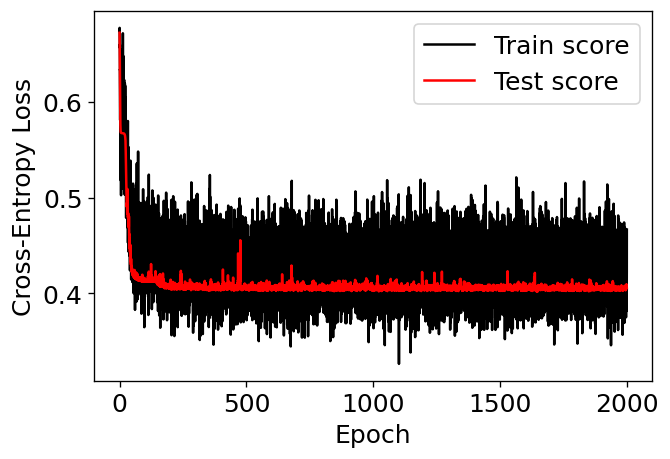

250 0.905123339658444 0.6662109300824124
500 0.9108159392789373 0.6787626751737496
750 0.9089184060721063 0.6712999886065854
1000 0.9127134724857685 0.6960616763510691
1250 0.9089184060721063 0.6712999886065854
1500 0.9108159392789373 0.6836808324788273
1750 0.905123339658444 0.6662109300824124
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 98.4+/-11.288932633336067
TN = 382.6+/-4.841487374764082
FP = 8.6+/-2.33238075793812
FN = 37.4+/-11.324310133513652
Acc = 0.9127134724857685+/-0.020821050055931975
TSS = 0.7027124248038451+/-0.08088924891348406
=>=>=> NUMBER OF EPOCHS: 500
TP = 101.8+/-13.496666255042392
TN = 378.2+/-10.361467077590895
FP = 13.0+/-7.58946638440411
FN = 34.0+/-13.114877048604
Acc = 0.9108159392789374+/-0.026969014048485576
TSS = 0.7161133574407301+/-0.09413537172271552
=>=>=> NUMBER OF EPOCHS: 750
TP = 101.8+/-14.756693396557374
TN = 383.2+/-6.046486583132389
FP = 8.0+/-3.03315017762062
FN = 34.0+/-14.352

In [ ]:
# NETWORK: VDFCNN_6060_CNN3_CONN1
ARCH = 'VDFCNN_6060_CNN3_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:01<00:00, 16.51it/s]


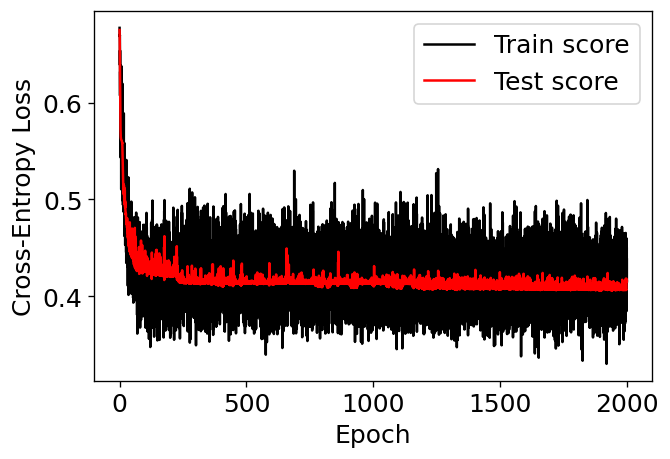

250 0.8956356736242884 0.6412541506049387
500 0.8994307400379506 0.6463302927369184
750 0.8975332068311196 0.6437922216709286
1000 0.9013282732447818 0.6488683638029084
1250 0.9013282732447818 0.6538490897293996
1500 0.9089184060721063 0.664001373993359
1750 0.8994307400379506 0.626407389030953
---------------------------------------------


100%|██████████| 2000/2000 [02:02<00:00, 16.31it/s]


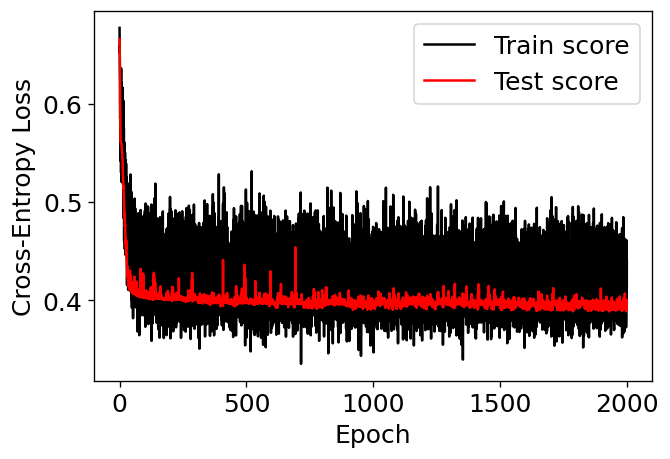

250 0.9146110056925996 0.6965192168237854
500 0.9127134724857685 0.6939811457577956
750 0.9146110056925996 0.6865577649708027
1000 0.9146110056925996 0.6915384908972939
1250 0.9127134724857685 0.7039425976107783
1500 0.920303605313093 0.7140948818747376
1750 0.9259962049335864 0.706766917293233
---------------------------------------------


100%|██████████| 2000/2000 [02:02<00:00, 16.35it/s]


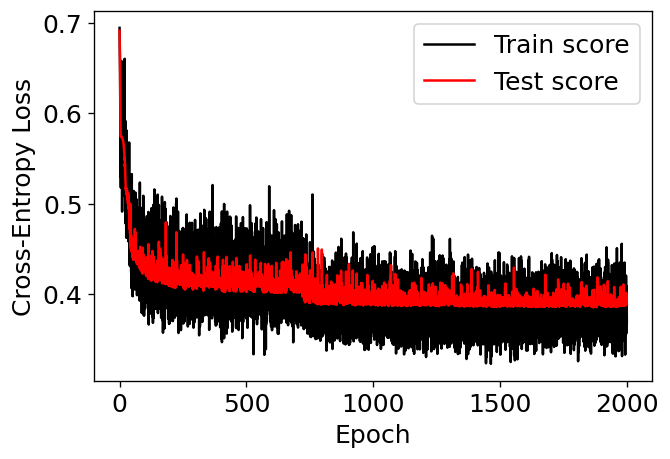

250 0.8823529411764706 0.6555291848995031
500 0.9146110056925996 0.6901097678558185
750 0.9240986717267552 0.7260809908774012
1000 0.9165085388994307 0.7203886375435733
1250 0.9297912713472486 0.7476637246903508
1500 0.9146110056925996 0.7362790180226952
1750 0.9222011385199241 0.7188867462730847
---------------------------------------------


100%|██████████| 2000/2000 [02:03<00:00, 16.22it/s]


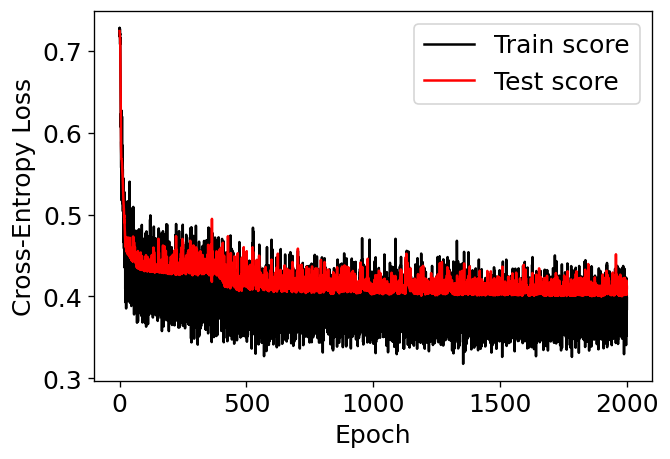

250 0.8500948766603416 0.5770394979697305
500 0.8975332068311196 0.6781100036913991
750 0.8994307400379506 0.6578995939461056
1000 0.9146110056925996 0.728719084533038
1250 0.9146110056925996 0.7196013289036545
1500 0.9089184060721063 0.7209671465485419
1750 0.9165085388994307 0.7221853082318199
---------------------------------------------


100%|██████████| 2000/2000 [02:03<00:00, 16.15it/s]


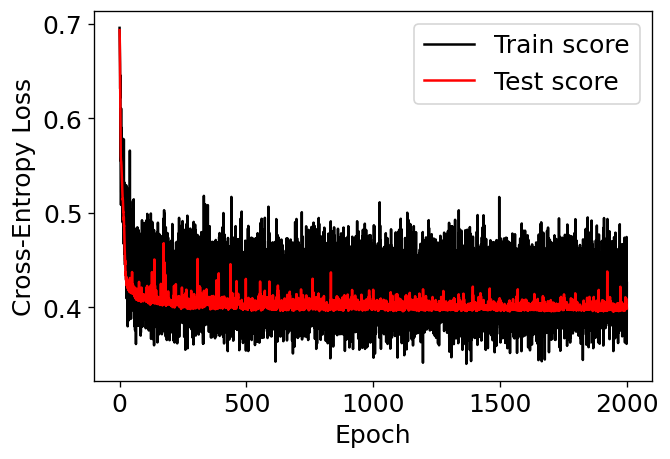

250 0.9070208728652751 0.6835099312597319
500 0.9070208728652751 0.6884280885648095
750 0.9089184060721063 0.6860544605218184
1000 0.8994307400379506 0.6241502411606092
1250 0.9165085388994307 0.701150734875242
1500 0.9146110056925996 0.6789335763928449
1750 0.9070208728652751 0.6540009874292659
---------------------------------------------
ARCH = VDFCNN_6060_CNN2_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 94.0+/-3.3466401061363023
TN = 375.0+/-11.949895397031725
FP = 16.2+/-8.97552226892675
FN = 41.8+/-3.7094473981982814
Acc = 0.889943074003795+/-0.022707059281444526
TSS = 0.650770396311538+/-0.041747531899141294
=>=>=> NUMBER OF EPOCHS: 500
TP = 95.4+/-3.6110940170535577
TN = 382.2+/-4.791659420284375
FP = 9.0+/-3.63318042491699
FN = 40.4+/-2.3323807579381204
Acc = 0.9062618595825427+/-0.0068521708103482844
TSS = 0.6793918597213482+/-0.0173440746071451
=>=>=> NUMBER OF EPOCHS: 750
TP = 94.8+/-4.214261501141095
TN = 384.2+/-3.1874754901018454
FP = 7.0+/-2.6076809620810595
FN = 41.0+/-3.0

In [ ]:
# NETWORK: VDFCNN_6060_CNN2_CONN2
ARCH = 'VDFCNN_6060_CNN2_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:04<00:00, 16.08it/s]


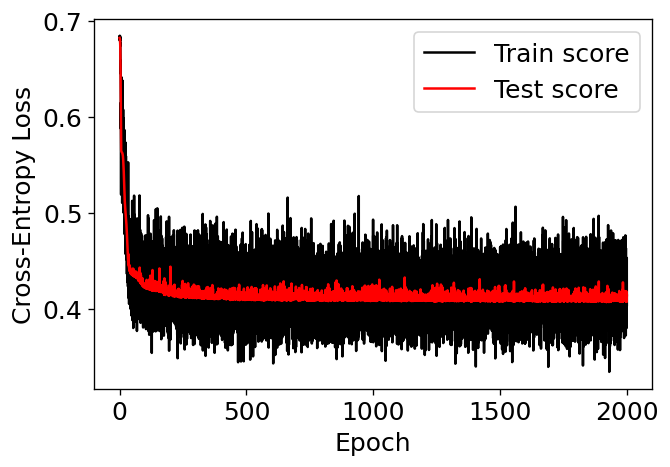

250 0.8975332068311196 0.633830769817946
500 0.905123339658444 0.6589252318613793
750 0.9032258064516129 0.6563871607953895
1000 0.9089184060721063 0.6689820999198504
1250 0.9070208728652751 0.6664440288538606
1500 0.9013282732447818 0.658829815655891
1750 0.8937381404174574 0.6486775313919316
---------------------------------------------


100%|██████████| 2000/2000 [02:10<00:00, 15.35it/s]


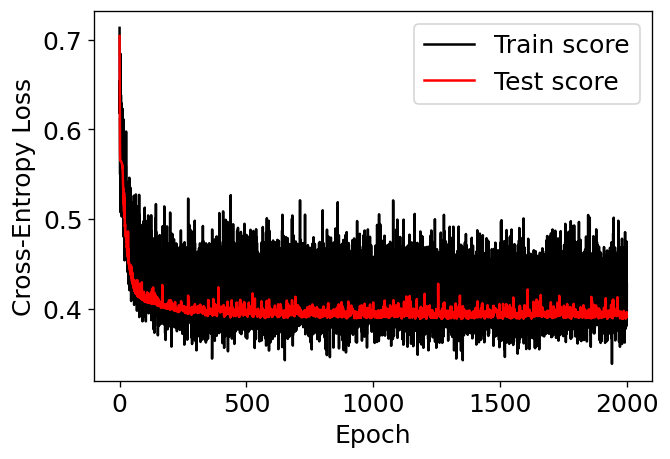

250 0.9146110056925996 0.6965192168237854
500 0.9146110056925996 0.6865577649708027
750 0.9184060721062619 0.7165375367352391
1000 0.9184060721062619 0.7165375367352391
1250 0.9184060721062619 0.7165375367352391
1500 0.9259962049335864 0.706766917293233
1750 0.9240986717267552 0.6992481203007519
---------------------------------------------


100%|██████████| 2000/2000 [01:58<00:00, 16.81it/s]


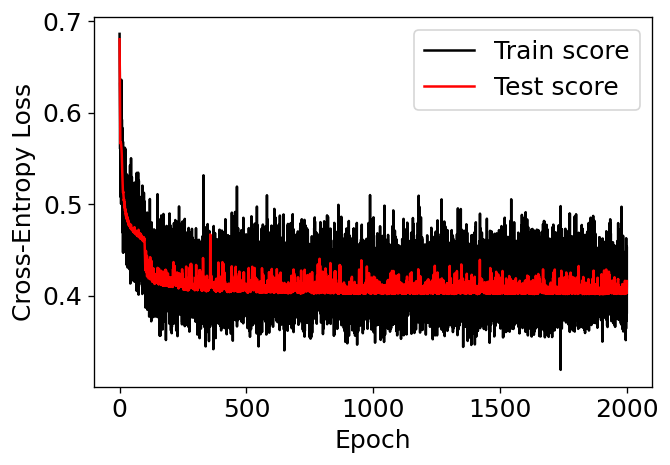

250 0.9070208728652751 0.6751835644886153
500 0.9070208728652751 0.6751835644886153
750 0.9070208728652751 0.6798004895053029
1000 0.9108159392789373 0.694188978713936
1250 0.9089184060721063 0.6777608840762442
1500 0.9108159392789373 0.6757212786471853
1750 0.9127134724857685 0.682915523251502
---------------------------------------------


100%|██████████| 2000/2000 [02:03<00:00, 16.23it/s]


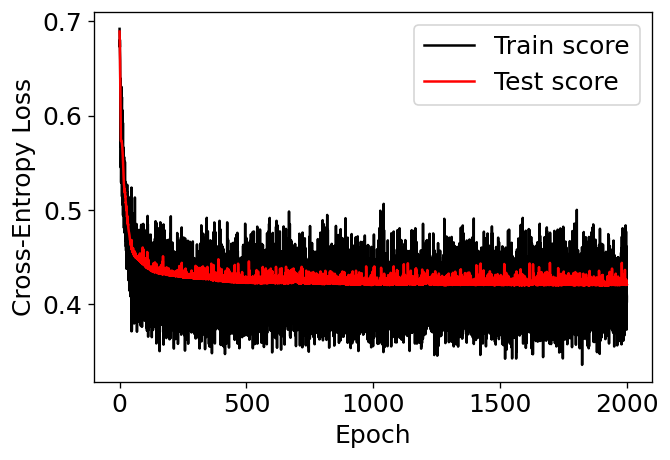

250 0.888045540796964 0.6150424510889627
500 0.889943074003795 0.6176264304171281
750 0.889943074003795 0.599390919158361
1000 0.8918406072106262 0.6202104097452934
1250 0.8956356736242884 0.6299372462163161
1500 0.8956356736242884 0.6299372462163161
1750 0.8842504743833017 0.5825212255444814
---------------------------------------------


100%|██████████| 2000/2000 [01:59<00:00, 16.71it/s]


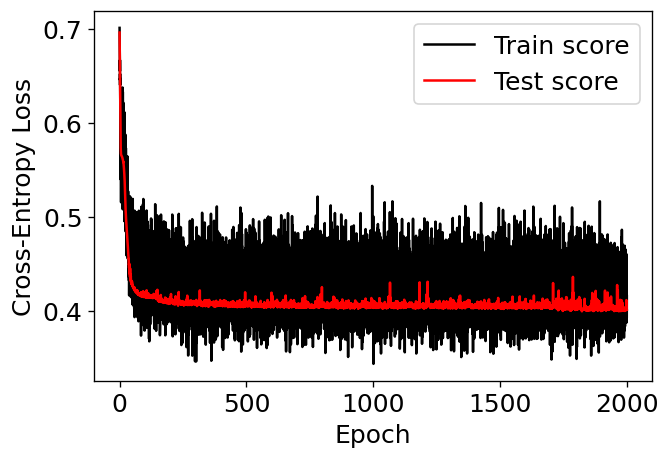

250 0.905123339658444 0.6563746154722571
500 0.9032258064516129 0.6685845581254035
750 0.9089184060721063 0.6712999886065854
1000 0.9070208728652751 0.6540009874292659
1250 0.9089184060721063 0.6663818313015077
1500 0.905123339658444 0.67112908738749
1750 0.9089184060721063 0.6614636739964301
---------------------------------------------
ARCH = VDFCNN_6060_CNN2_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 91.4+/-3.49857113690718
TN = 384.2+/-3.1874754901018454
FP = 7.0+/-0.8944271909999159
FN = 44.4+/-4.223742416388575
Acc = 0.9024667931688803+/-0.009028749338421469
TSS = 0.6553901235383133+/-0.02890360617094745
=>=>=> NUMBER OF EPOCHS: 500
TP = 92.2+/-2.4819347291981715
TN = 384.2+/-3.3105890714493698
FP = 7.0+/-1.6733200530681511
FN = 43.6+/-3.878143885933063
Acc = 0.9039848197343453+/-0.008014691492198434
TSS = 0.6613755099726658+/-0.023650642851113086
=>=>=> NUMBER OF EPOCHS: 750
TP = 92.4+/-4.758150901348127
TN = 384.8+/-2.1354156504062622
FP = 6.4+/-1.8547236990991407
FN = 43.4+/-6.46

In [ ]:
# NETWORK: VDFCNN_6060_CNN2_CONN1
ARCH = 'VDFCNN_6060_CNN2_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:44<00:00, 19.19it/s]


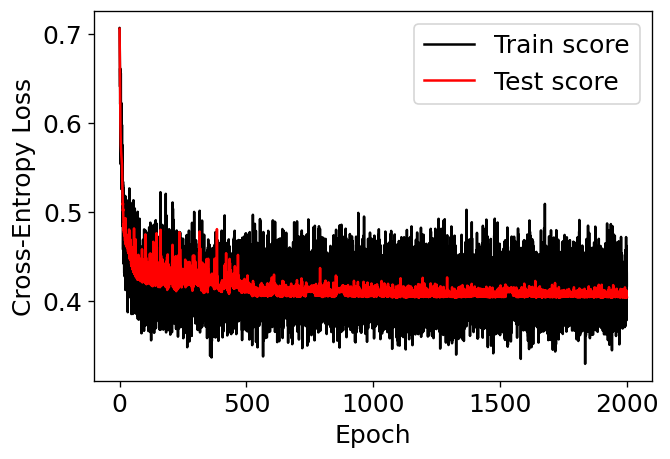

250 0.8918406072106262 0.6411587343994504
500 0.8994307400379506 0.6463302927369184
750 0.9013282732447818 0.658829815655891
1000 0.8994307400379506 0.6662531964428838
1250 0.8975332068311196 0.663715125376894
1500 0.9070208728652751 0.6564825770008779
1750 0.9089184060721063 0.664001373993359
---------------------------------------------


100%|██████████| 2000/2000 [01:44<00:00, 19.06it/s]


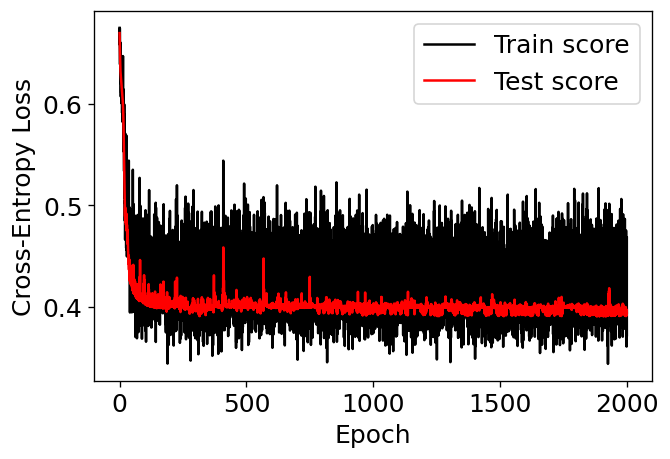

250 0.9127134724857685 0.6840196939048128
500 0.9127134724857685 0.6890004198313041
750 0.9146110056925996 0.6815770390443112
1000 0.9127134724857685 0.6989618716842868
1250 0.9184060721062619 0.6866531811762909
1500 0.9222011385199241 0.6967100492347621
1750 0.9108159392789373 0.6765008969123315
---------------------------------------------


100%|██████████| 2000/2000 [01:45<00:00, 18.95it/s]


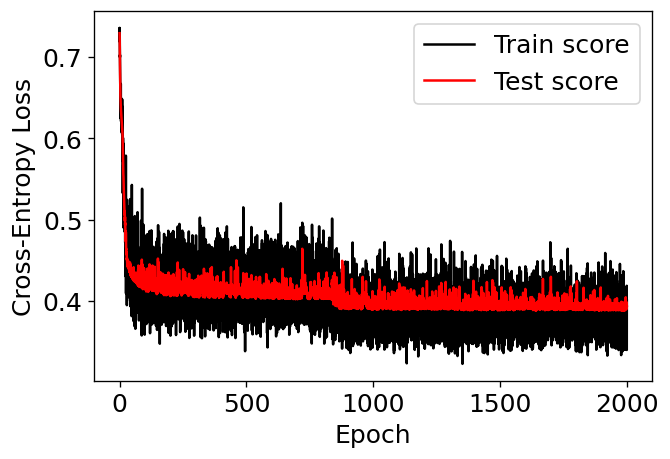

250 0.905123339658444 0.6772231699176741
500 0.9108159392789373 0.6849551286805607
750 0.9127134724857685 0.696766298301565
1000 0.9240986717267552 0.7491656159608395
1250 0.9222011385199241 0.7373544463398353
1500 0.9278937381404174 0.745086405102722
1750 0.9222011385199241 0.7373544463398353
---------------------------------------------


100%|██████████| 2000/2000 [01:48<00:00, 18.42it/s]


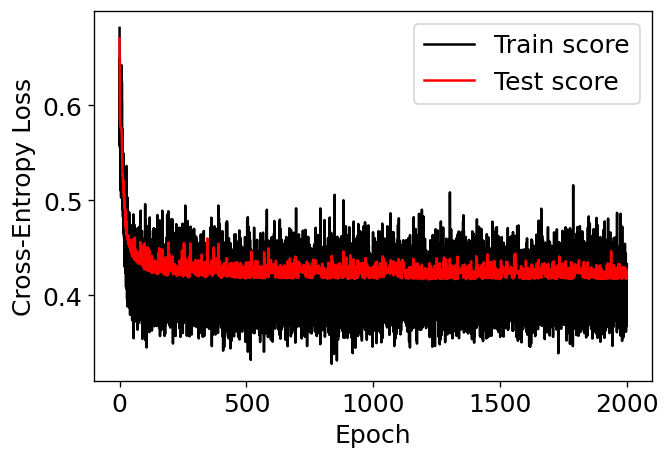

250 0.8956356736242884 0.6253783684016242
500 0.8937381404174574 0.6227943890734589
750 0.8937381404174574 0.6227943890734589
1000 0.888045540796964 0.628719084533038
1250 0.8975332068311196 0.6370801033591732
1500 0.8975332068311196 0.6325212255444814
1750 0.8937381404174574 0.6410299003322258
---------------------------------------------


100%|██████████| 2000/2000 [01:58<00:00, 16.84it/s]


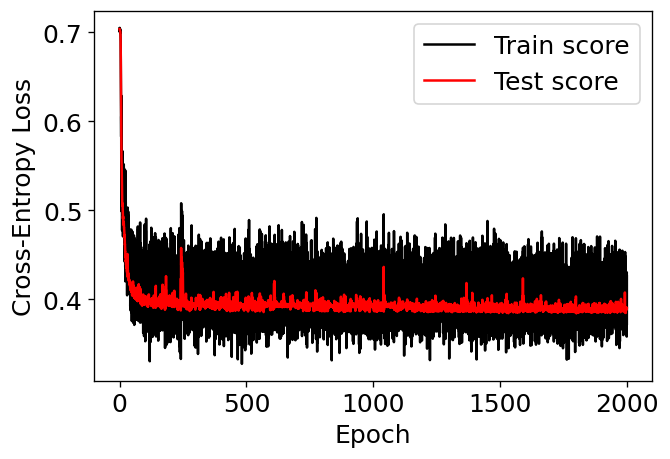

250 0.8918406072106262 0.6090539668071855
500 0.920303605313093 0.7308305799248034
750 0.9184060721062619 0.7233678933576393
1000 0.9222011385199241 0.7432114237970453
1250 0.9259962049335864 0.7335460104059854
1500 0.9222011385199241 0.7530477384072006
1750 0.9278937381404174 0.7508450115833049
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 90.6+/-4.31740662898458
TN = 383.4+/-3.2
FP = 7.8+/-3.3704599092705436
FN = 45.2+/-4.445222154178573
Acc = 0.8994307400379506+/-0.008227507927392338
TSS = 0.6473667866861493+/-0.029067995617775833
=>=>=> NUMBER OF EPOCHS: 500
TP = 94.0+/-4.6475800154489
TN = 384.2+/-1.7204650534085253
FP = 7.0+/-1.7888543819998317
FN = 41.8+/-5.912698199637793
Acc = 0.9074003795066412+/-0.009555733064147358
TSS = 0.6747821620494092+/-0.0373076685338008
=>=>=> NUMBER OF EPOCHS: 750
TP = 94.2+/-4.445222154178574
TN = 384.4+/-2.939387691339814
FP = 6.8+/-2.3151673805580453
FN = 41.6+/-5.4626001134990645
Ac

In [ ]:
# NETWORK: VDFCNN_6060_CNN1_CONN2
ARCH = 'VDFCNN_6060_CNN1_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:45<00:00, 18.95it/s]


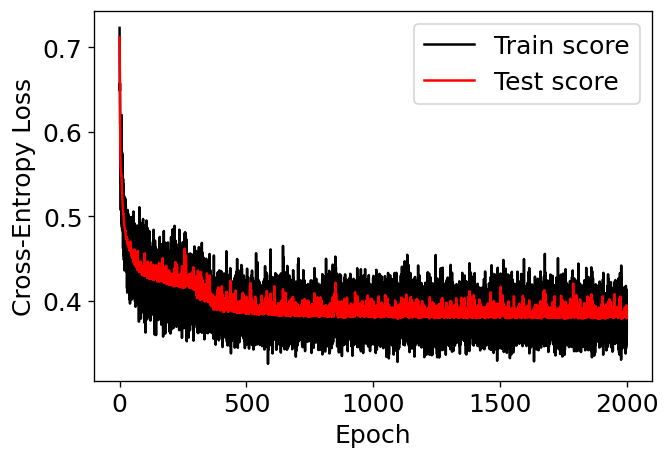

250 0.8937381404174574 0.668600435097897
500 0.920303605313093 0.7439792374336858
750 0.9240986717267552 0.7490553795656655
1000 0.9108159392789373 0.7611732376626846
1250 0.9297912713472486 0.7616503186901263
1500 0.9316888045540797 0.7542269379031334
1750 0.9259962049335864 0.776497080264112
---------------------------------------------


100%|██████████| 2000/2000 [01:43<00:00, 19.26it/s]


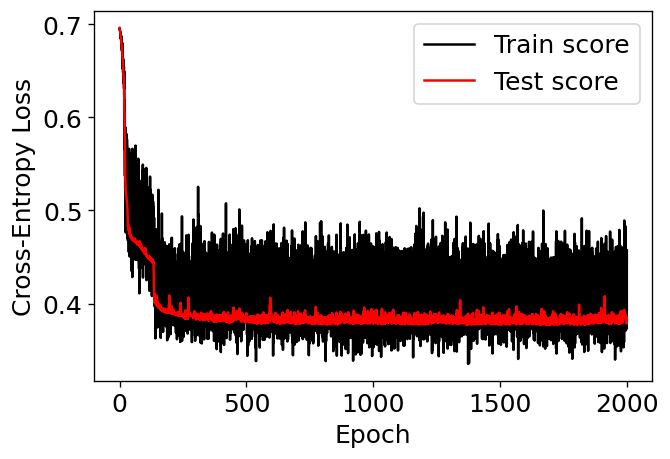

250 0.9278937381404174 0.7541315216976452
500 0.9278937381404174 0.7640929735506279
750 0.9278937381404174 0.7541315216976452
1000 0.937381404174573 0.7668218770275944
1250 0.9278937381404174 0.7640929735506279
1500 0.9297912713472486 0.7317659631311781
1750 0.9354838709677419 0.7543223541086218
---------------------------------------------


100%|██████████| 2000/2000 [01:45<00:00, 18.99it/s]


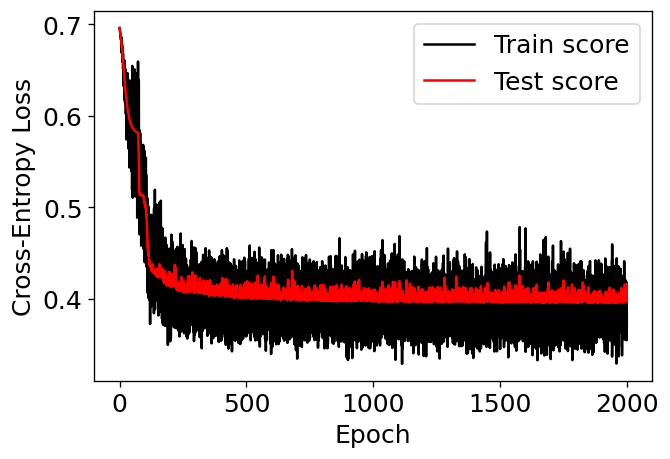

250 0.9127134724857685 0.7106170733516279
500 0.9165085388994307 0.7019209374768227
750 0.9127134724857685 0.7152339983683156
1000 0.9184060721062619 0.7275828821478899
1250 0.9240986717267552 0.7260809908774012
1500 0.9184060721062619 0.7183490321145145
1750 0.905123339658444 0.7095416450344879
---------------------------------------------


100%|██████████| 2000/2000 [01:48<00:00, 18.47it/s]


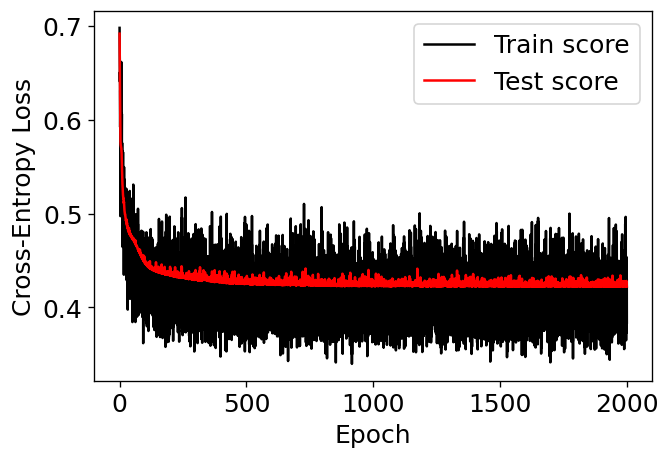

250 0.8861480075901328 0.6033407161314138
500 0.889943074003795 0.6176264304171281
750 0.8956356736242884 0.6253783684016242
1000 0.8994307400379506 0.6396640826873385
1250 0.8956356736242884 0.6253783684016242
1500 0.8937381404174574 0.6227943890734589
1750 0.8937381404174574 0.6319121447028424
---------------------------------------------


100%|██████████| 2000/2000 [01:47<00:00, 18.55it/s]


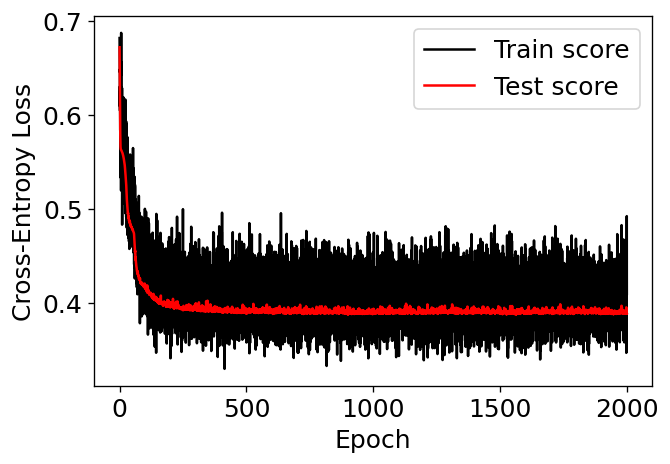

250 0.9240986717267552 0.7359196384489765
500 0.9297912713472486 0.7484713835403137
750 0.9240986717267552 0.7506741103642095
1000 0.9240986717267552 0.7408377957540542
1250 0.9259962049335864 0.7335460104059854
1500 0.9184060721062619 0.7332042079677946
1750 0.9297912713472486 0.7533895408453913
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 97.6+/-5.986651818838306
TN = 381.4+/-3.97994974842648
FP = 9.8+/-4.166533331199932
FN = 38.2+/-7.934733769950949
Acc = 0.9089184060721063+/-0.016455015854784656
TSS = 0.694521876945512+/-0.05387404753160915
=>=>=> NUMBER OF EPOCHS: 500
TP = 99.6+/-5.642694391866353
TN = 383.6+/-2.65329983228432
FP = 7.6+/-3.0066592756745814
FN = 36.2+/-8.44748483277715
Acc = 0.9168880455407968+/-0.014321033976556529
TSS = 0.7152181924837157+/-0.05295788073625908
=>=>=> NUMBER OF EPOCHS: 750
TP = 100.4+/-5.71314274283428
TN = 382.8+/-2.6381811916545836
FP = 8.4+/-2.33238075793812
FN = 35.4+/-8.13879597

In [ ]:
# NETWORK: VDFCNN_6060_CNN1_CONN1
ARCH = 'VDFCNN_6060_CNN1_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

## Best Network Architecture

CONCLUSION:

Best network configuration: VDFCNN_6060_CNN1_CONN1 with 1250 epochs

Running for the best configuration now...

100%|██████████| 1250/1250 [01:11<00:00, 17.50it/s]


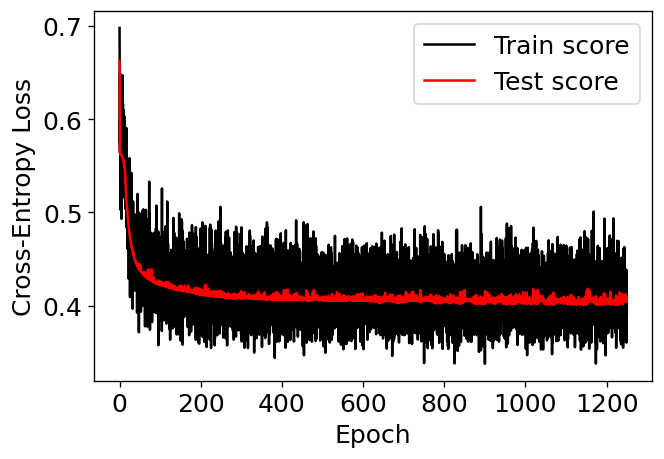

0.9032258064516129 -1
0.9032258064516129 0.6613678867218808
---------------------------------------------


100%|██████████| 1250/1250 [01:07<00:00, 18.39it/s]


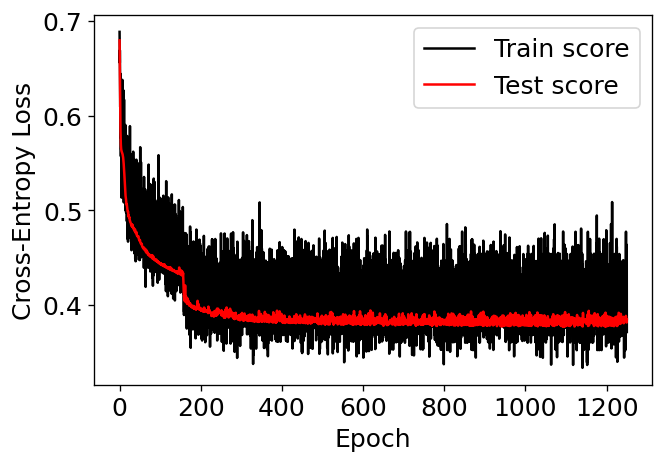

0.9297912713472486 -1
0.9297912713472486 0.7367466890576696
---------------------------------------------


100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


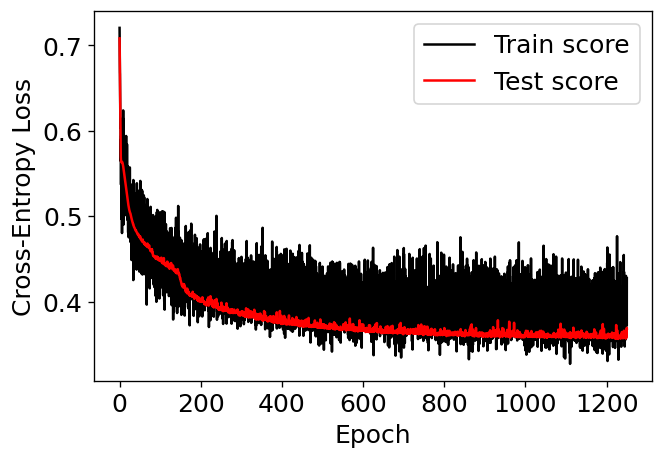

0.9430740037950665 -1
0.9430740037950665 0.8580434621375065
---------------------------------------------


100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


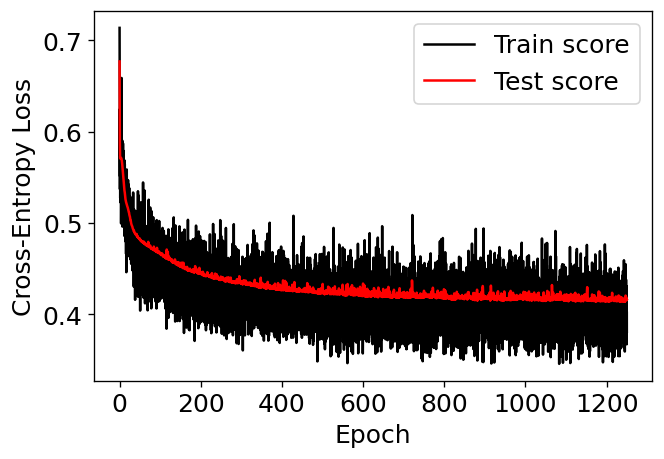

0.8975332068311196 -1
0.8975332068311196 0.6325212255444814
---------------------------------------------


100%|██████████| 1250/1250 [01:07<00:00, 18.64it/s]


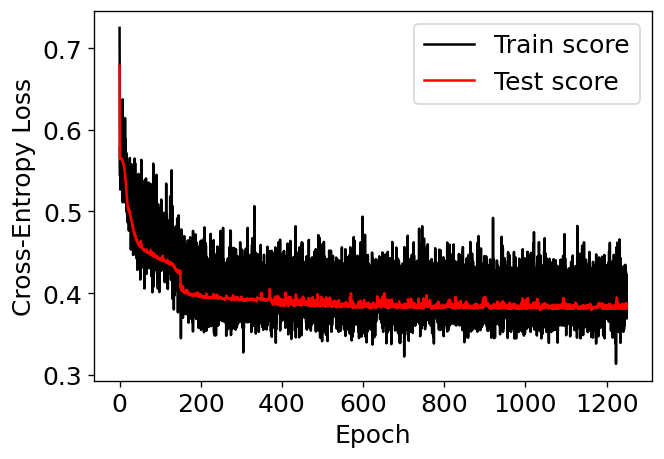

0.9259962049335864 -1
0.9259962049335864 0.7581367969313737
---------------------------------------------


100%|██████████| 1250/1250 [01:08<00:00, 18.23it/s]


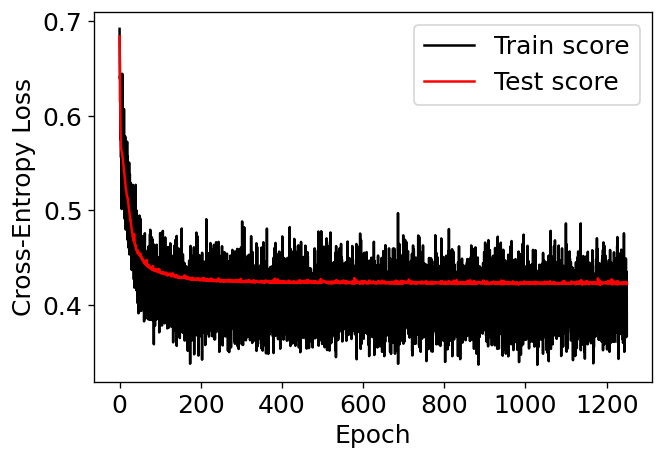

0.8785578747628083 -1
RERUNNING THE SAMPLE...


100%|██████████| 1250/1250 [01:08<00:00, 18.32it/s]


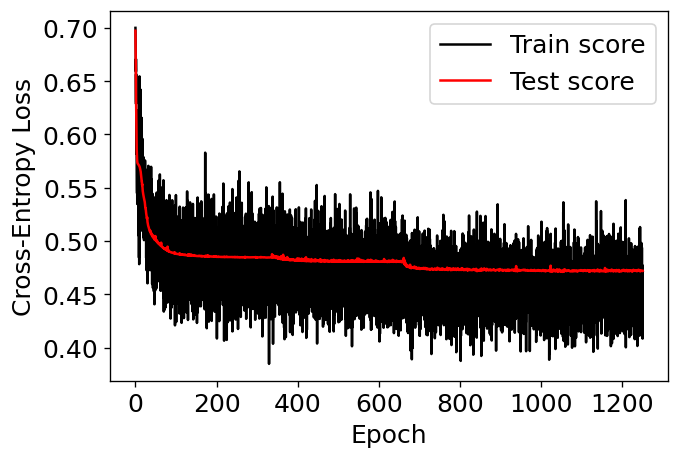

<ipython-input-13-be7d2eddc1a2>:3: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


0.7362428842504743 -1
RERUNNING THE SAMPLE...


100%|██████████| 1250/1250 [01:08<00:00, 18.21it/s]


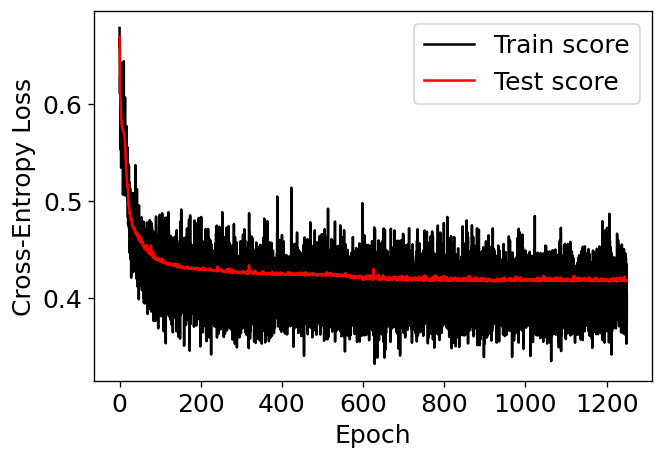

0.8956356736242884 -1
0.8956356736242884 0.60431654676259
---------------------------------------------


100%|██████████| 1250/1250 [01:08<00:00, 18.27it/s]


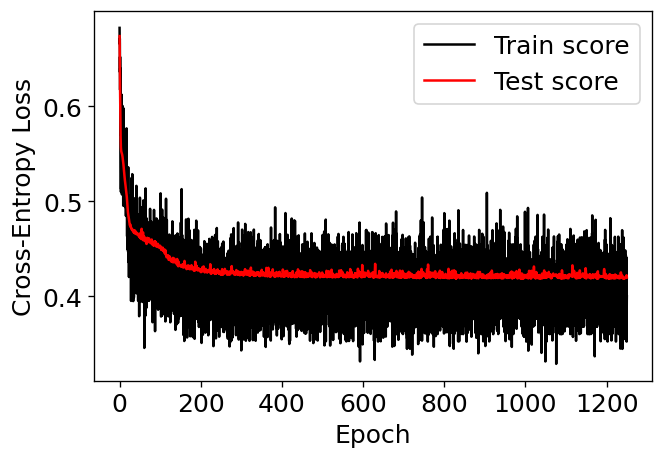

0.8937381404174574 -1
0.8937381404174574 0.6520054253051734
---------------------------------------------


100%|██████████| 1250/1250 [01:08<00:00, 18.34it/s]


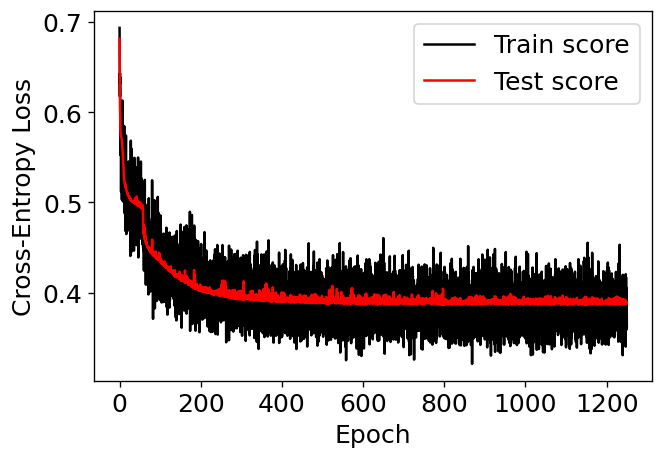

0.9165085388994307 -1
0.9165085388994307 0.7388563376103241
---------------------------------------------


100%|██████████| 1250/1250 [01:08<00:00, 18.18it/s]


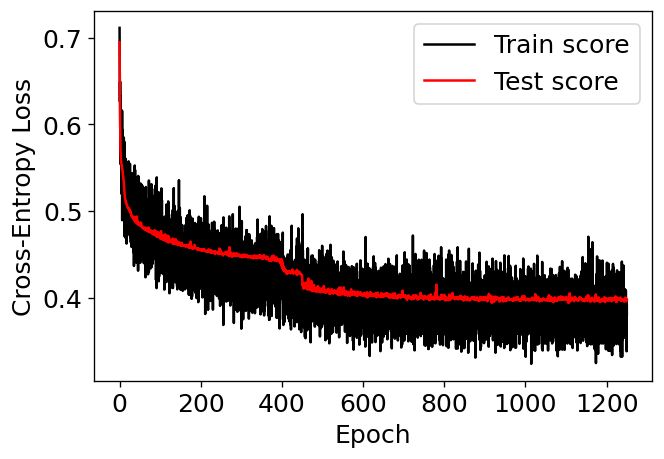

0.9146110056925996 -1
0.9146110056925996 0.7035565424019321
---------------------------------------------


100%|██████████| 1250/1250 [01:09<00:00, 18.06it/s]


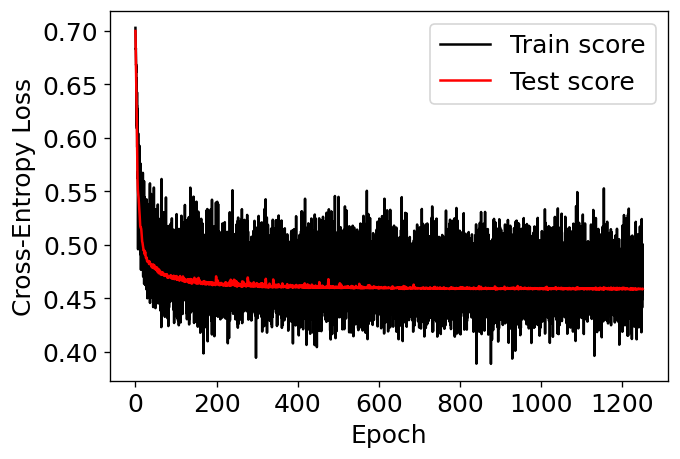

<ipython-input-13-be7d2eddc1a2>:3: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


0.7590132827324478 -1
RERUNNING THE SAMPLE...


100%|██████████| 1250/1250 [01:08<00:00, 18.21it/s]


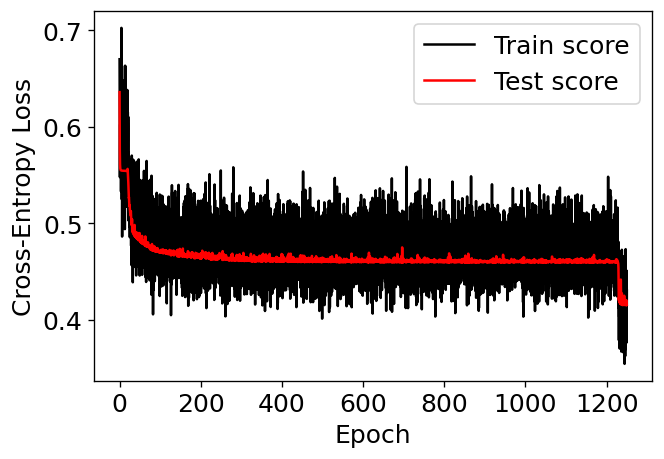

0.8994307400379506 -1
0.8994307400379506 0.6794094488188976
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN1
TP = 97.7+/-11.331813623599711
TN = 382.9+/-5.412023651093923
FP = 9.8+/-5.706137047074843
FN = 36.6+/-10.772186407596184
Acc = 0.9119544592030362+/-0.01597087317836874
TSS = 0.702496036129183+/-0.07006903926926596


In [16]:
# NETWORK: VDFCNN_6060_CNN1_CONN1
ARCH = 'VDFCNN_6060_CNN1_CONN1'

tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1250
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Tests for individual runs

Implementation of early stopping is necessary here. The runs behave very active

In [ ]:
simfiles = ['particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
    'particles.d11_A0.75Hepp_beta1_256',\
    'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
    'particles.d11_E11Ap4.3Aa1.6',\
    'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
    'particles.d11_He++A10_256_iden0eps0',\
    'particles.d11_He++v2_256_iden0eps1e-4t600',\
    'particles.d11_He++vd1.5_256_iden0eps1e-4',\
    'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
    'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
    'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
    'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
    'particles.d11_vap1.5Ap1.5Aa1rdna_0.007']

In [ ]:
def outputclass_analysis_scorereturn_spec(test_labels, predicted_labels):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(test_labels)):
        if ( (test_labels[i] == 0) and (predicted_labels[i] == 0) ): tn += 1
        if ( (test_labels[i] == 0) and (predicted_labels[i] == 1) ): fp += 1
        if ( (test_labels[i] == 1) and (predicted_labels[i] == 0) ): fn += 1
        if ( (test_labels[i] == 1) and (predicted_labels[i] == 1) ): tp += 1
    acc = (tp+tn)/(tp+fn+fp+tn)
    if ( ((tp + fn) == 0) or ((fp + tn) == 0) ):
      tss = -1
    else:
      tss = tp/(tp+fn) - fp/(fp+tn)
    return tp, tn, fp, fn, acc, tss

100%|██████████| 800/800 [01:06<00:00, 12.04it/s]


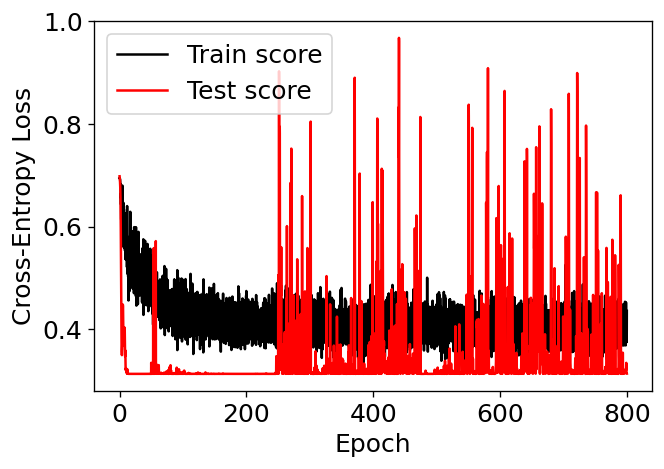

Optimal epoch count for the current training: 144
1.0 1299
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.95it/s]


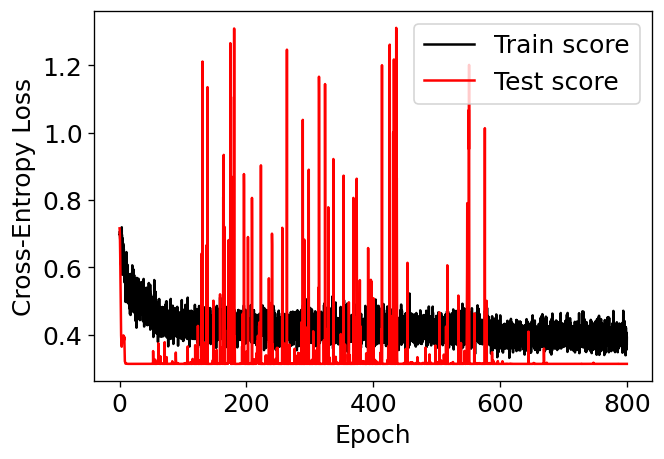

Optimal epoch count for the current training: 39
1.0 356
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.84it/s]


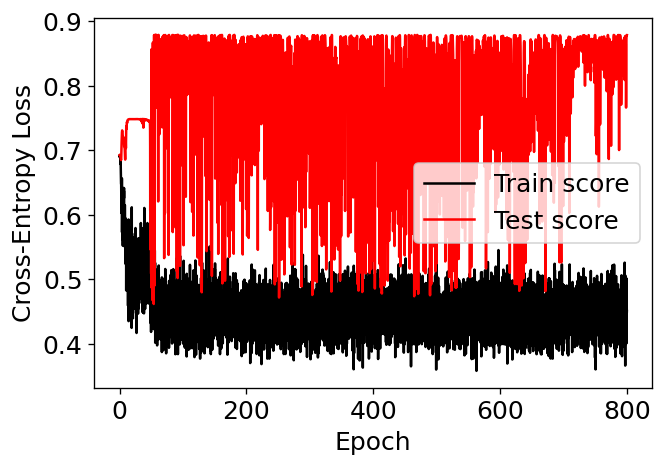

Optimal epoch count for the current training: 53
0.9130434782608695 485
0.9130434782608695 0.8
---------------------------------------------


100%|██████████| 800/800 [00:49<00:00, 16.01it/s]


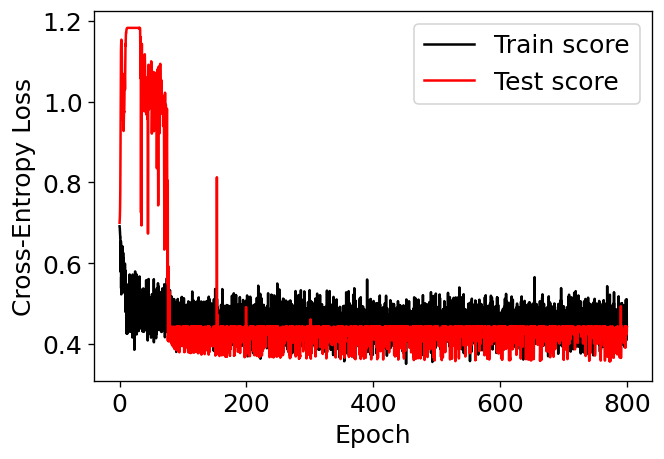

Optimal epoch count for the current training: 773
0.9565217391304348 6958
0.9565217391304348 0.8083333333333333
---------------------------------------------


100%|██████████| 800/800 [00:49<00:00, 16.06it/s]


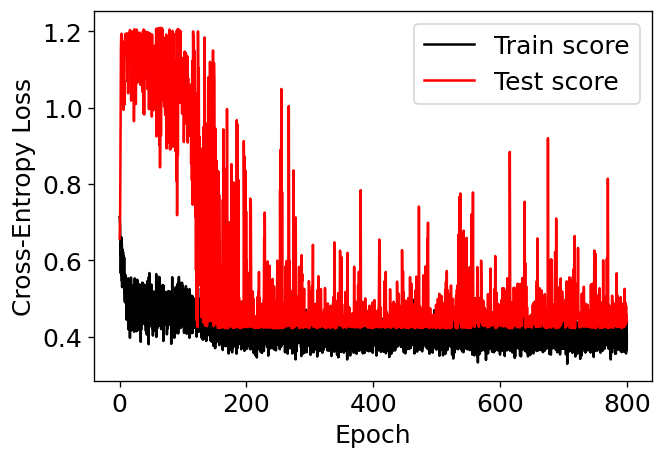

Optimal epoch count for the current training: 532
0.8913043478260869 4793
0.8913043478260869 0.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


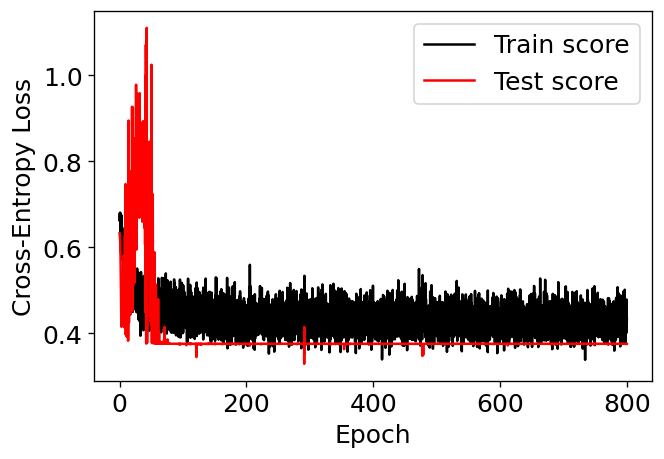

Optimal epoch count for the current training: 291
1.0 2620
1.0 1.0
---------------------------------------------


100%|██████████| 800/800 [00:52<00:00, 15.16it/s]


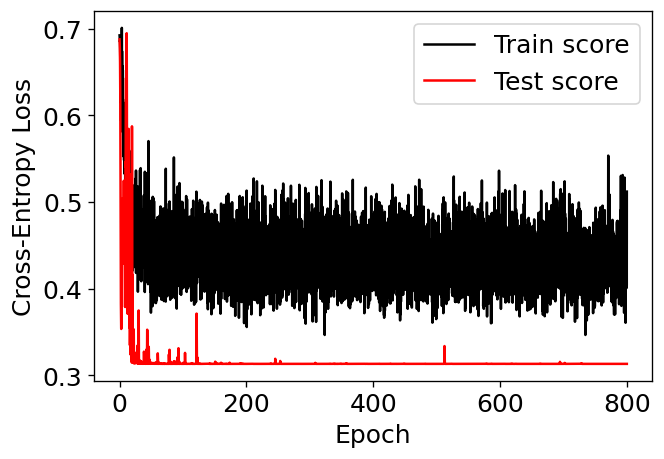

Optimal epoch count for the current training: 85
1.0 770
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.51it/s]


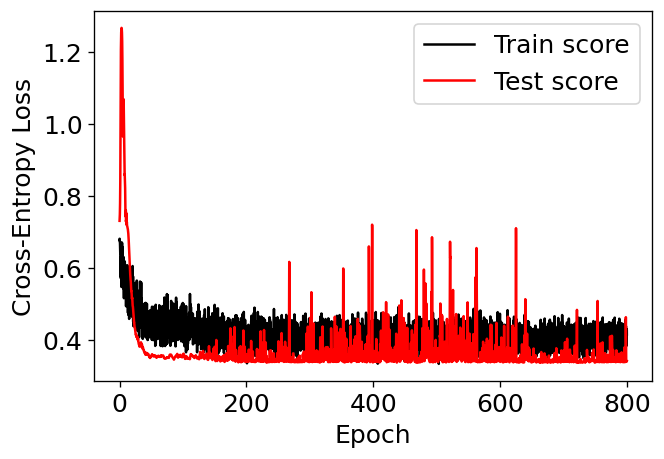

Optimal epoch count for the current training: 662
0.9782608695652174 5965
0.9782608695652174 0.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.93it/s]


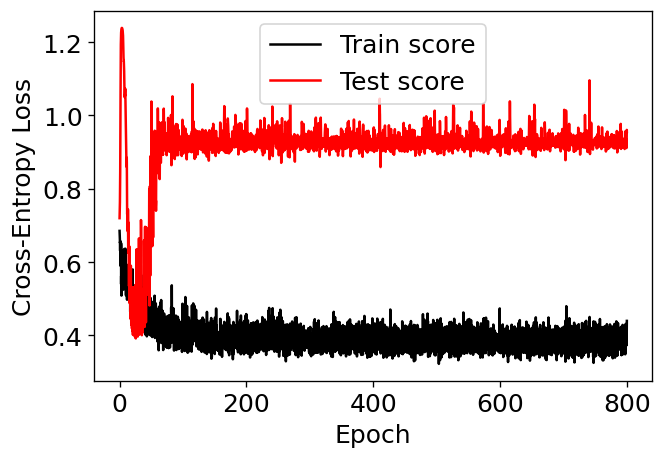

Optimal epoch count for the current training: 25
0.9333333333333333 230
0.9333333333333333 0.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.99it/s]


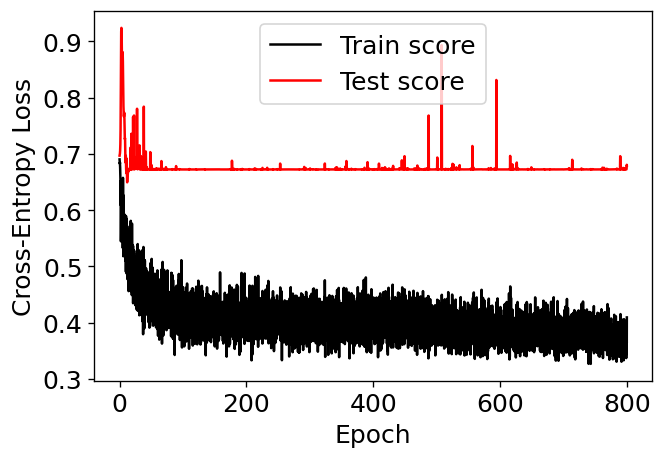

Optimal epoch count for the current training: 12
0.6410256410256411 108
0.6410256410256411 0.0
---------------------------------------------


100%|██████████| 800/800 [00:50<00:00, 15.81it/s]


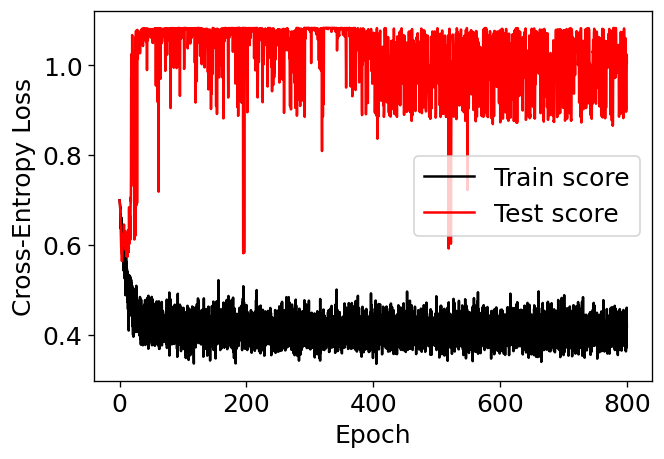

Optimal epoch count for the current training: 3
0.7702702702702703 33
0.7702702702702703 0.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.53it/s]


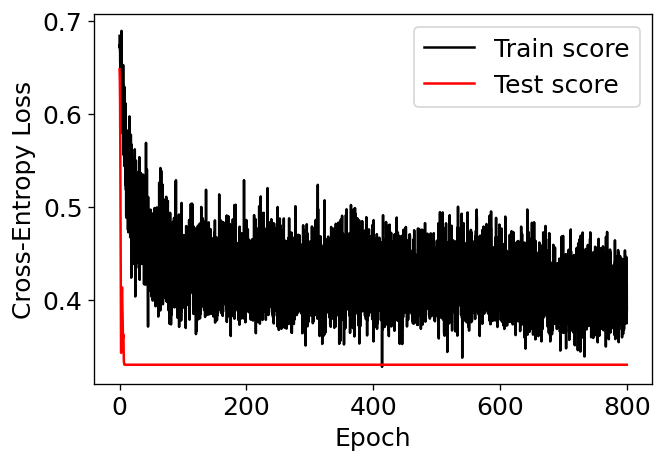

Optimal epoch count for the current training: 10
0.9827586206896551 90
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.68it/s]


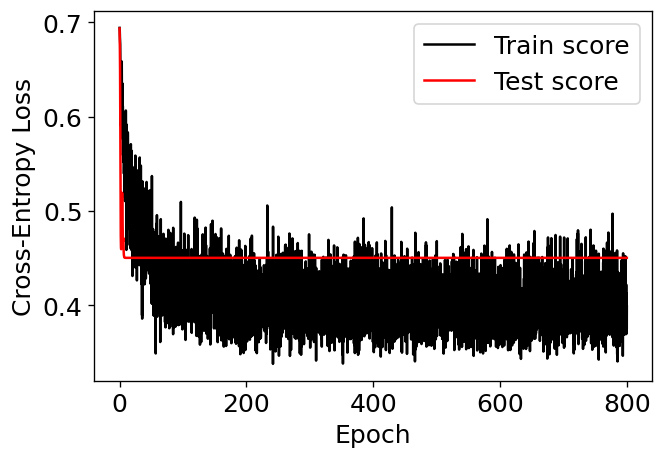

Optimal epoch count for the current training: 12
0.863013698630137 111
0.863013698630137 0.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.64it/s]


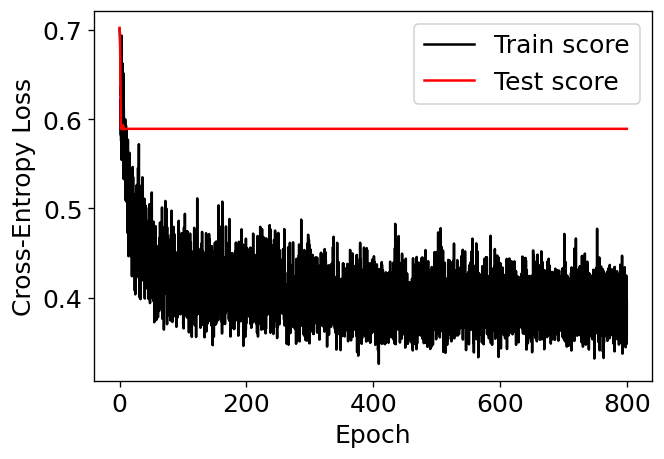

Optimal epoch count for the current training: 7
0.7241379310344828 68
0.7241379310344828 0.0
---------------------------------------------


100%|██████████| 800/800 [00:51<00:00, 15.60it/s]


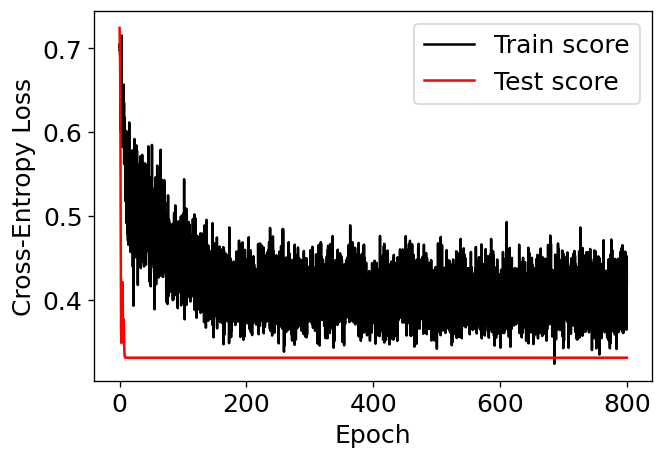

Optimal epoch count for the current training: 10
0.9827586206896551 92
0.9827586206896551 0.0
---------------------------------------------


 61%|██████    | 486/800 [00:31<00:20, 15.31it/s]


KeyboardInterrupt: 

In [ ]:
# NETWORK: VDFCNN_4040_CNN3_CONN2
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([22], dtype=int)
tn = np.zeros([22], dtype=int)
fp = np.zeros([22], dtype=int)
fn = np.zeros([22], dtype=int)
acc = np.zeros([22], dtype=float)
tss = np.zeros([22], dtype=float)

for n_e, simfile in enumerate(simfiles):

  train_index = np.where(simnames != simfile)[0]
  test_index = np.where(simnames == simfile)[0]

  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 800
    n_iterations = 9 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn_spec(f_test, labels_optim)

    print(_acc, optim_index)
    #if (_acc < 0.88):
      #print("RERUNNING THE SAMPLE...")
      #continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn_spec(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

print(acc)

print(tss)

100%|██████████| 800/800 [01:02<00:00, 12.80it/s]


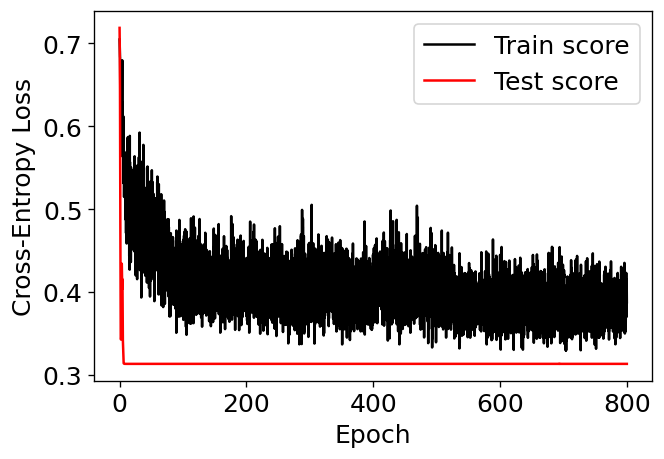

Optimal epoch count for the current training: 10
1.0 97
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.35it/s]


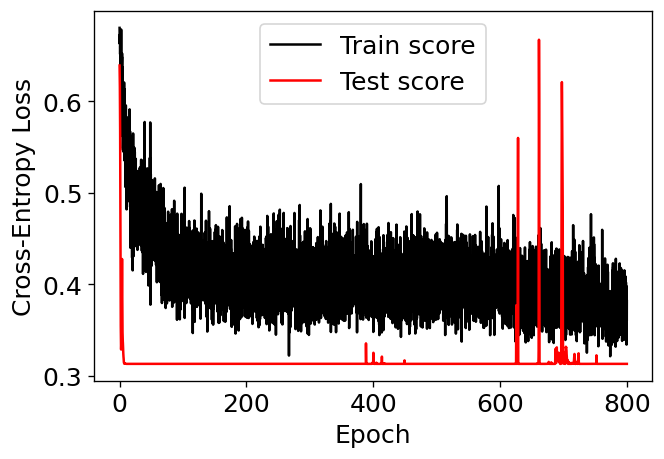

Optimal epoch count for the current training: 11
1.0 103
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.35it/s]


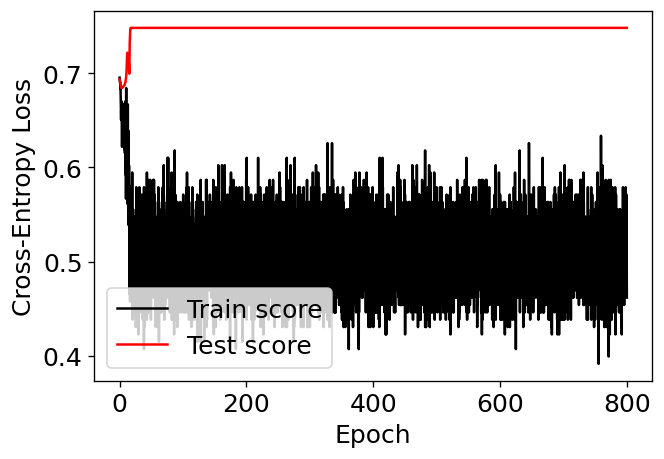

Optimal epoch count for the current training: 2
0.5652173913043478 21
0.5652173913043478 0.0
---------------------------------------------


100%|██████████| 800/800 [01:01<00:00, 13.04it/s]


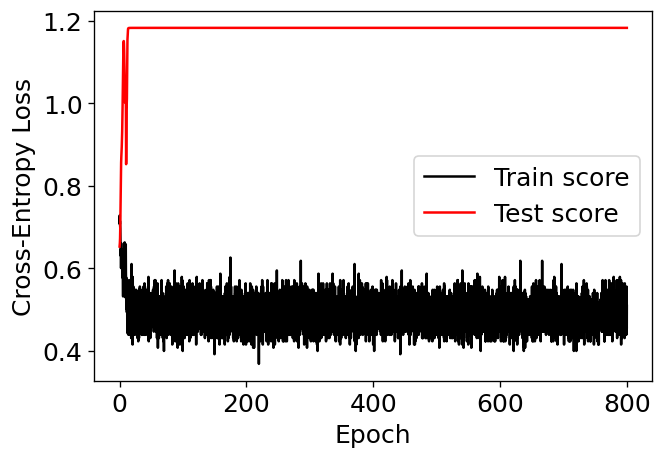

Optimal epoch count for the current training: 0
0.8695652173913043 0
0.8695652173913043 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.58it/s]


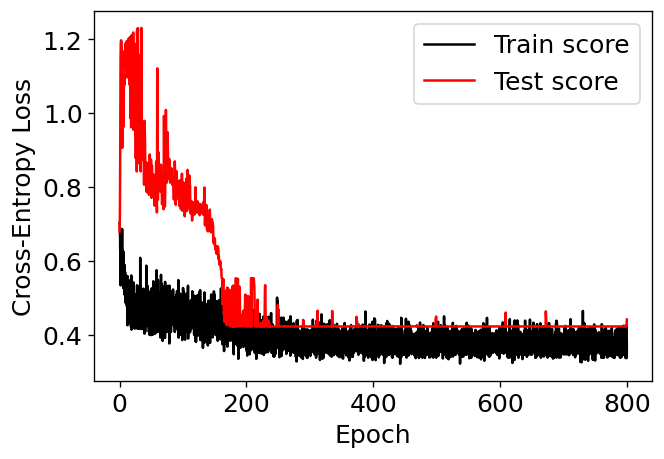

Optimal epoch count for the current training: 692
0.8913043478260869 6234
0.8913043478260869 0.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.40it/s]


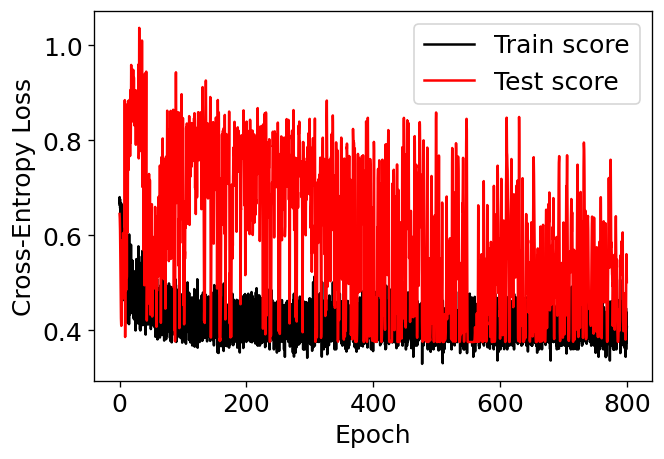

Optimal epoch count for the current training: 555
0.9375 5002
0.9375 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.53it/s]


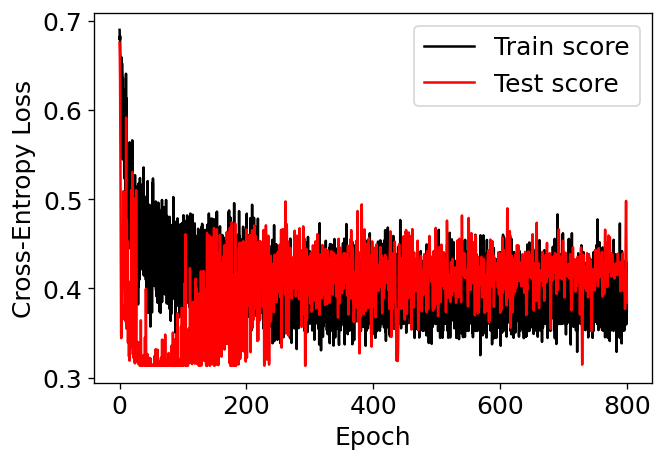

Optimal epoch count for the current training: 86
1.0 777
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.44it/s]


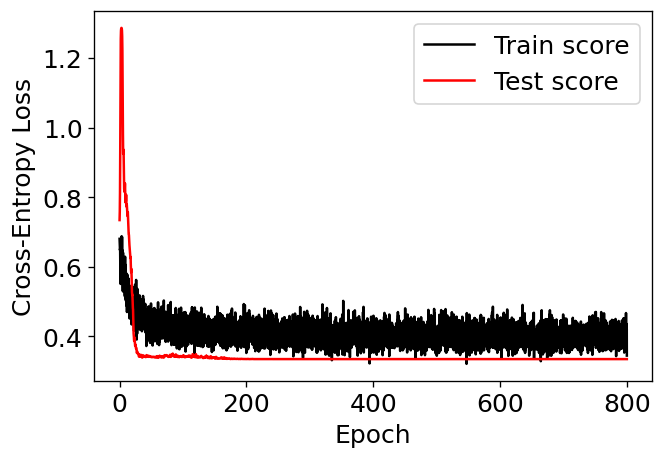

Optimal epoch count for the current training: 300
0.9782608695652174 2705
0.9782608695652174 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.55it/s]


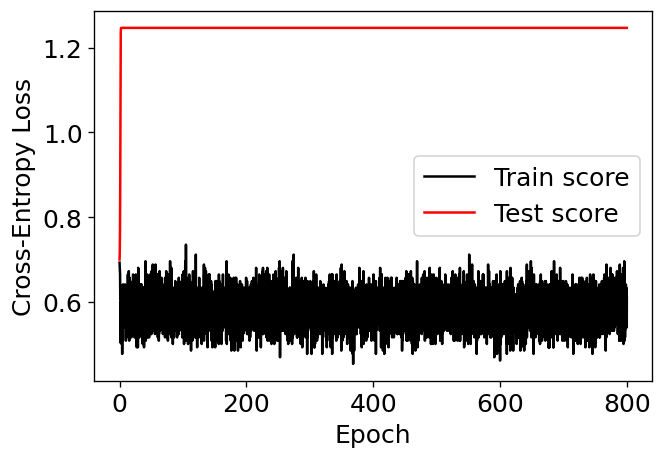

Optimal epoch count for the current training: 0
0.06666666666666667 0
0.06666666666666667 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.54it/s]


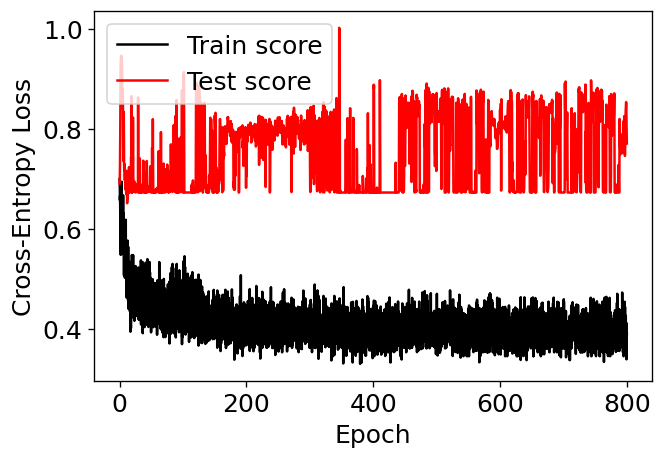

Optimal epoch count for the current training: 11
0.6410256410256411 107
0.6410256410256411 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.54it/s]


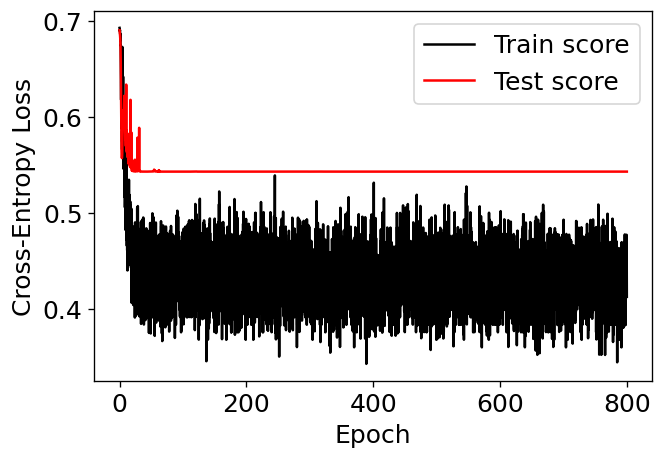

Optimal epoch count for the current training: 511
0.7702702702702703 4600
0.7702702702702703 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.68it/s]


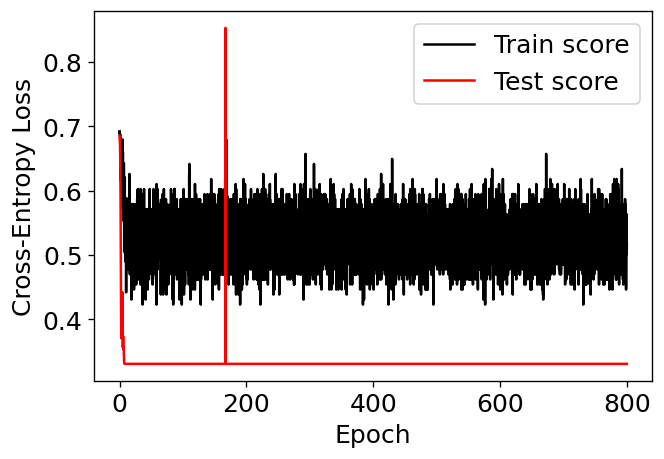

Optimal epoch count for the current training: 9
0.9827586206896551 82
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.61it/s]


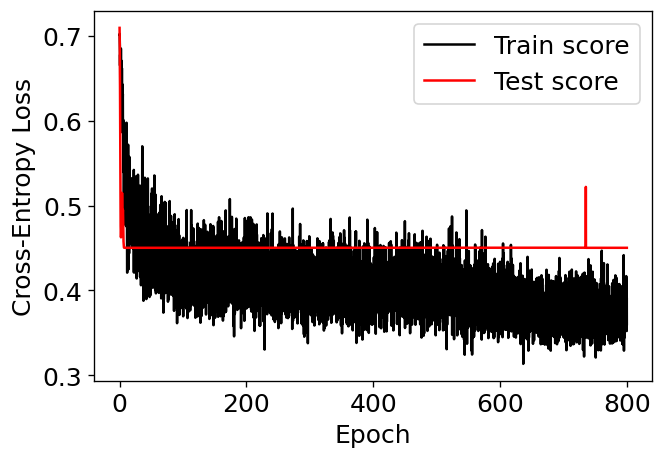

Optimal epoch count for the current training: 9
0.863013698630137 88
0.863013698630137 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.62it/s]


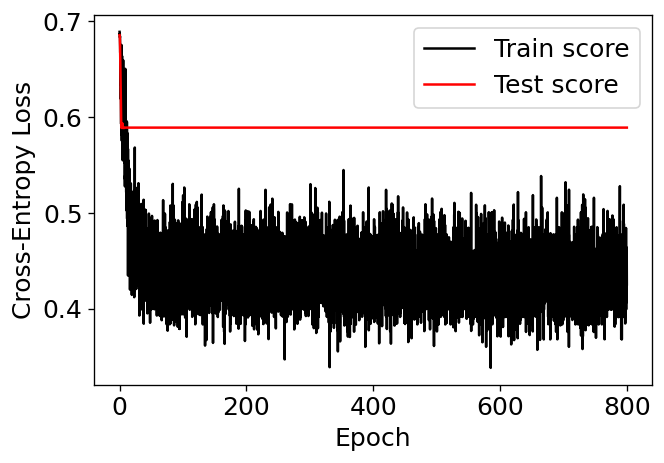

Optimal epoch count for the current training: 5
0.7241379310344828 49
0.7241379310344828 0.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.47it/s]


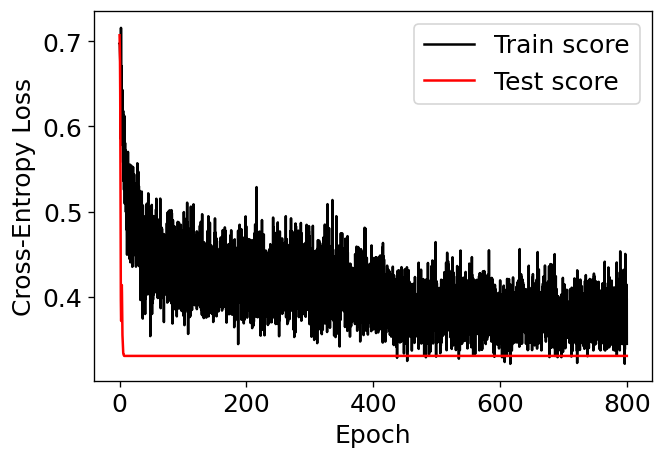

Optimal epoch count for the current training: 8
0.9827586206896551 76
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.37it/s]


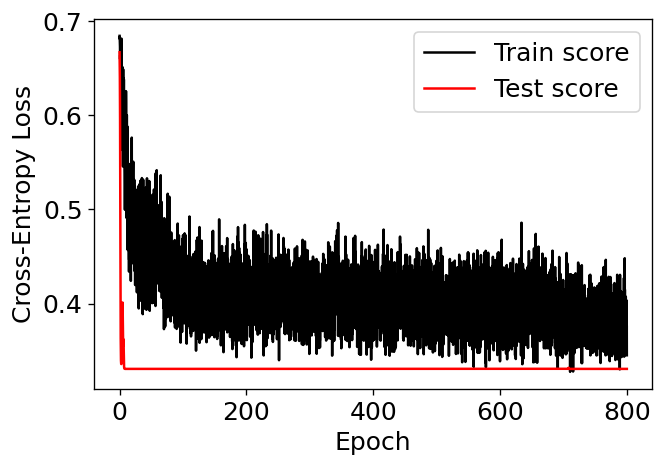

Optimal epoch count for the current training: 9
0.9827586206896551 82
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 800/800 [01:03<00:00, 12.69it/s]


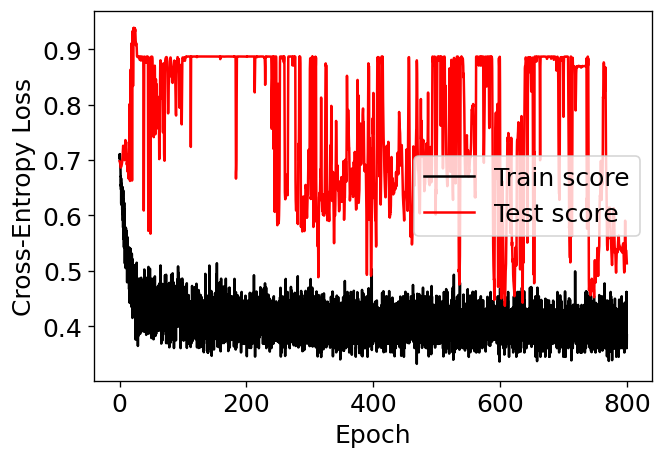

Optimal epoch count for the current training: 607
0.9180327868852459 5468
0.9180327868852459 0.8224400871459695
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.48it/s]


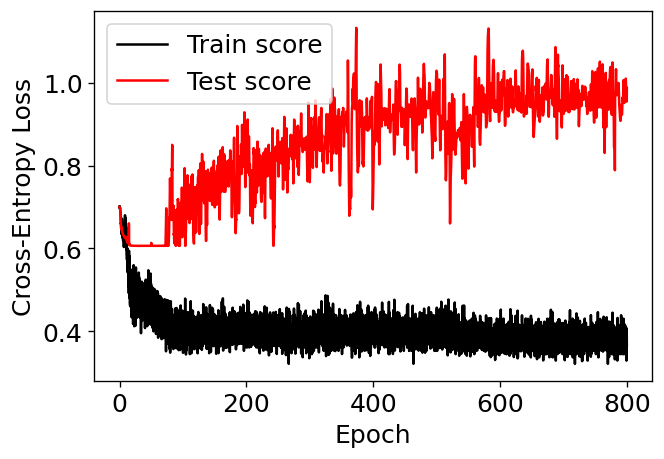

Optimal epoch count for the current training: 75
0.7068965517241379 678
0.7068965517241379 0.0
---------------------------------------------


100%|██████████| 800/800 [01:02<00:00, 12.81it/s]


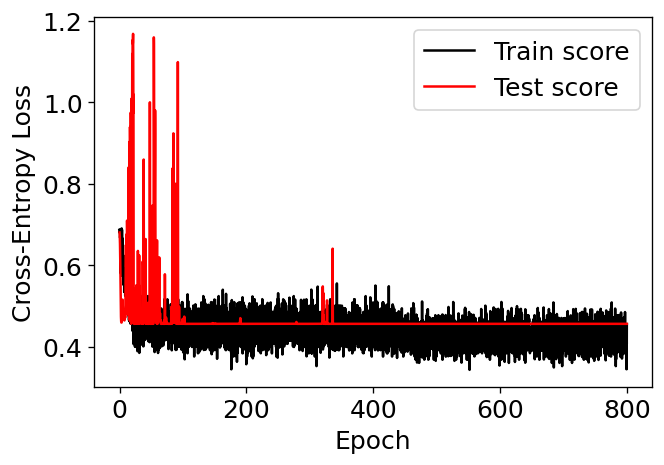

Optimal epoch count for the current training: 106
0.8571428571428571 962
0.8571428571428571 0.0
---------------------------------------------


100%|██████████| 800/800 [01:01<00:00, 13.04it/s]


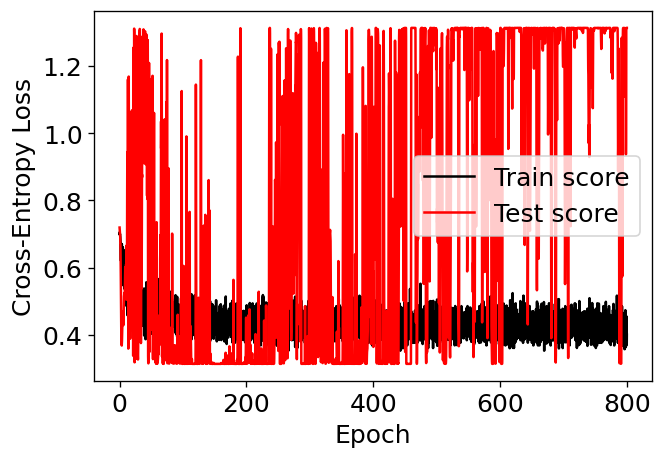

Optimal epoch count for the current training: 115
1.0 1041
1.0 -1.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.46it/s]


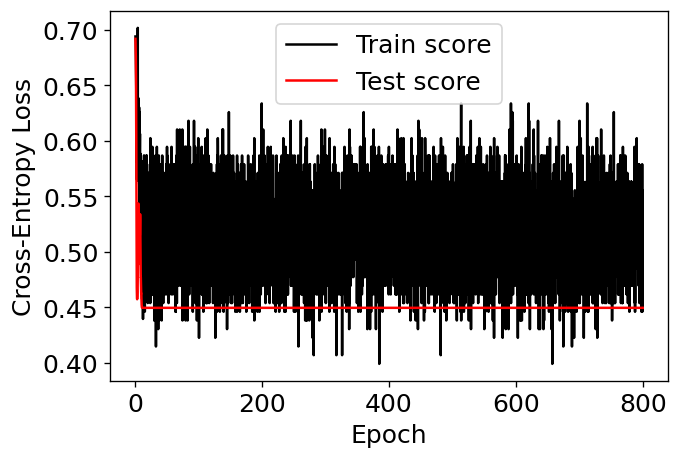

Optimal epoch count for the current training: 12
0.8636363636363636 109
0.8636363636363636 0.0
---------------------------------------------


100%|██████████| 800/800 [01:04<00:00, 12.39it/s]


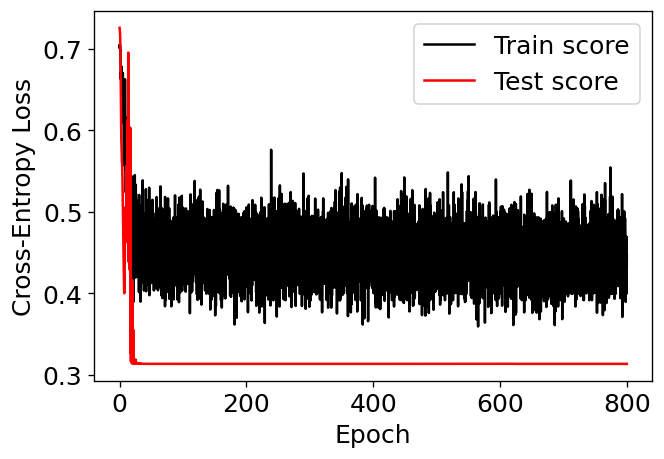

Optimal epoch count for the current training: 87
1.0 786
1.0 -1.0
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN2
TP = 9.045454545454545+/-17.234946719666763
TN = 37.0+/-27.809416325475734
FP = 1.8636363636363635+/-5.918349390170561
FN = 9.045454545454545+/-18.48704035688311
Acc = 0.8454975661441693+/-0.21075821153275362
TSS = -0.1898890869479105+/-0.47112701720172245
[1.         1.         0.56521739 0.86956522 0.89130435 0.9375
 1.         0.97826087 0.06666667 0.64102564 0.77027027 0.98275862
 0.8630137  0.72413793 0.98275862 0.98275862 0.91803279 0.70689655
 0.85714286 1.         0.86363636 1.        ]
[-1.         -1.          0.          0.          0.          0.
 -1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.82244009  0.
  0.         -1.          0.         -1.        ]


In [ ]:
# NETWORK: VDFCNN_6060_CNN3_CONN2
ARCH = 'VDFCNN_6060_CNN3_CONN2'

tp = np.zeros([22], dtype=int)
tn = np.zeros([22], dtype=int)
fp = np.zeros([22], dtype=int)
fn = np.zeros([22], dtype=int)
acc = np.zeros([22], dtype=float)
tss = np.zeros([22], dtype=float)

for n_e, simfile in enumerate(simfiles):

  train_index = np.where(simnames != simfile)[0]
  test_index = np.where(simnames == simfile)[0]

  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 800
    n_iterations = 9 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn_spec(f_test, labels_optim)

    print(_acc, optim_index)
    #if (_acc < 0.88):
      #print("RERUNNING THE SAMPLE...")
      #continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn_spec(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

print(acc)

print(tss)

# Weight decay to prevent overfitting

In [ ]:
class VDFCNN_4040_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(32*5*5, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 32 * 5 * 5)
    x = self.linearcell(x)
    return x

In [ ]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

100%|██████████| 3000/3000 [03:06<00:00, 16.05it/s]


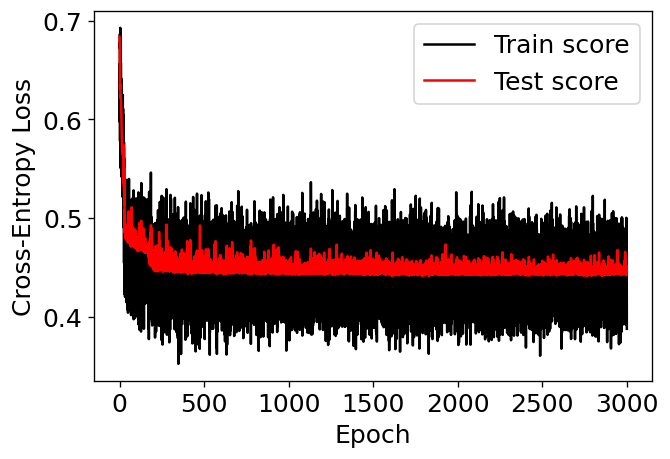

Optimal epoch count for the current training: 1611
0.8816425120772947 12890
0.8816425120772947 0.6630434782608696
---------------------------------------------


100%|██████████| 3000/3000 [03:21<00:00, 14.92it/s]


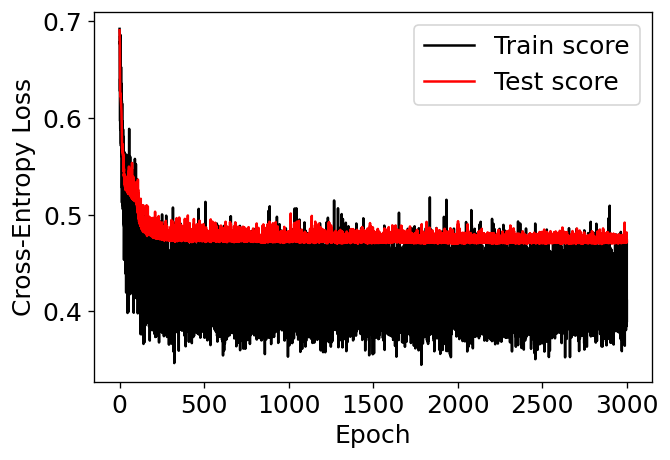

Optimal epoch count for the current training: 2851
0.857487922705314 22813
RERUNNING THE SAMPLE...


100%|██████████| 3000/3000 [03:05<00:00, 16.14it/s]


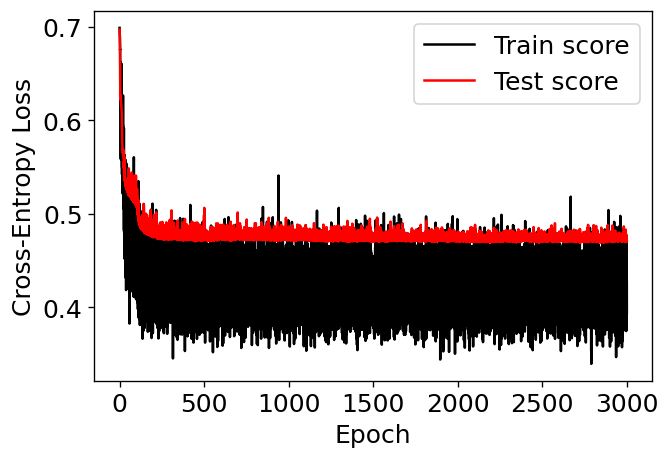

Optimal epoch count for the current training: 2863
0.855072463768116 22906
RERUNNING THE SAMPLE...


  4%|▍         | 131/3000 [00:08<03:07, 15.26it/s]


KeyboardInterrupt: 

In [ ]:
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 3000
    n_iterations = 8 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

100%|██████████| 20/20 [00:01<00:00, 12.51it/s]


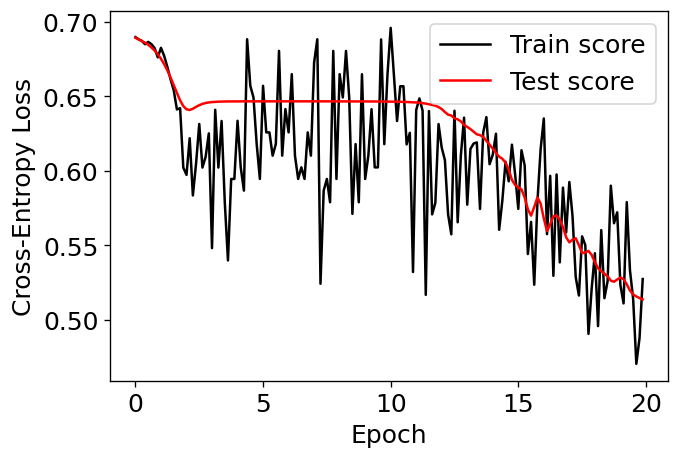

Optimal epoch count for the current training: 19
[0.6892232894897461, 0.688072919845581, 0.6870402693748474, 0.6858956813812256, 0.6844990849494934, 0.6827240586280823, 0.6806728839874268, 0.6781937479972839, 0.6751644611358643, 0.671521782875061, 0.6673073172569275, 0.6625561714172363, 0.6573930978775024, 0.6520962119102478, 0.6471993923187256, 0.6434027552604675, 0.6412366032600403, 0.64078688621521, 0.6415966749191284, 0.6428826451301575, 0.6440078616142273, 0.6448685526847839, 0.6454539895057678, 0.6458353400230408, 0.6460940837860107, 0.6462576389312744, 0.6463637948036194, 0.6464331150054932, 0.6464794278144836, 0.6465110778808594, 0.6465328931808472, 0.6465482115745544, 0.6465588808059692, 0.6465663313865662, 0.6465717554092407, 0.6465756297111511, 0.6465786695480347, 0.6465808153152466, 0.6465823650360107, 0.6465834975242615, 0.6465843319892883, 0.6465850472450256, 0.6465855836868286, 0.6465858221054077, 0.6465858817100525, 0.6465861201286316, 0.6465861201286316, 0.646585822105

100%|██████████| 20/20 [00:01<00:00, 13.52it/s]


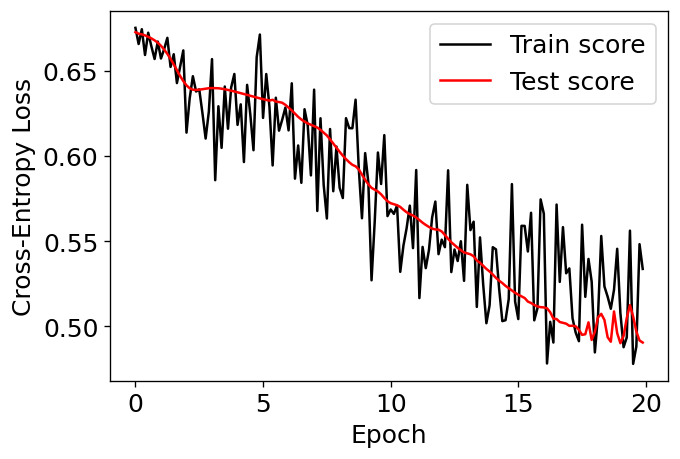

Optimal epoch count for the current training: 19
[0.6726625561714172, 0.6717956066131592, 0.6713944673538208, 0.6707658767700195, 0.6699758172035217, 0.6690084934234619, 0.6679021716117859, 0.6664831638336182, 0.6646808385848999, 0.6625092029571533, 0.6599297523498535, 0.6570004224777222, 0.6537926197052002, 0.650384783744812, 0.6469905972480774, 0.6439729332923889, 0.6414744853973389, 0.6397608518600464, 0.6389284729957581, 0.6387535333633423, 0.6389336585998535, 0.639234185218811, 0.6395473480224609, 0.6397894024848938, 0.6398884057998657, 0.6398085951805115, 0.6397687196731567, 0.639521062374115, 0.6391938328742981, 0.6388010382652283, 0.6383599638938904, 0.6378923654556274, 0.6374016404151917, 0.6368834972381592, 0.6363832950592041, 0.6358601450920105, 0.635334312915802, 0.6348486542701721, 0.634340226650238, 0.6338338851928711, 0.6333698630332947, 0.632934033870697, 0.6325437426567078, 0.6330015063285828, 0.6319455504417419, 0.6316812634468079, 0.6312638521194458, 0.63004505634307

100%|██████████| 20/20 [00:01<00:00, 13.39it/s]


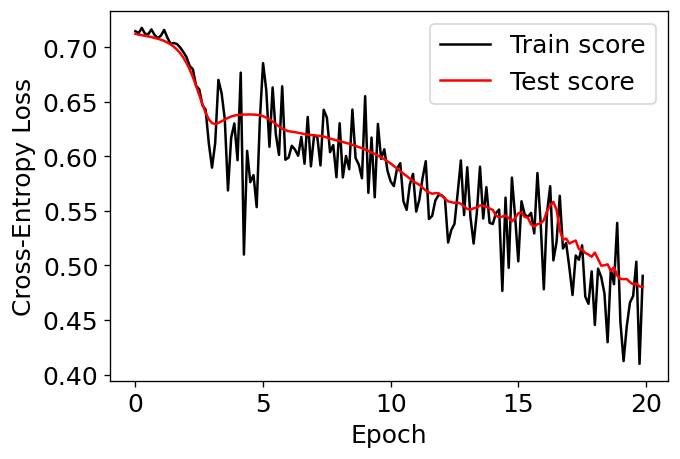

Optimal epoch count for the current training: 19
[0.7123036980628967, 0.7115694284439087, 0.7110217809677124, 0.7105302214622498, 0.7099422812461853, 0.709307074546814, 0.7085474133491516, 0.7077244520187378, 0.706874668598175, 0.7057697772979736, 0.7043258547782898, 0.7026666402816772, 0.7004773616790771, 0.6978452205657959, 0.694628119468689, 0.6905704140663147, 0.6855860352516174, 0.6796364784240723, 0.6726300716400146, 0.664739191532135, 0.6561862230300903, 0.6476965546607971, 0.6399151086807251, 0.6339853405952454, 0.6304035782814026, 0.6296365261077881, 0.6306450963020325, 0.6321505308151245, 0.6336420178413391, 0.6352144479751587, 0.6364848017692566, 0.6373112797737122, 0.6379040479660034, 0.6380303502082825, 0.6382960677146912, 0.6383718848228455, 0.6383706331253052, 0.6382580399513245, 0.6381369233131409, 0.6376806497573853, 0.6367653608322144, 0.6354445219039917, 0.6338599920272827, 0.6318206191062927, 0.6295536160469055, 0.6274293065071106, 0.6253389120101929, 0.623961806297

100%|██████████| 20/20 [00:01<00:00, 13.98it/s]


KeyboardInterrupt: 

In [ ]:
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([5], dtype=int)
tn = np.zeros([5], dtype=int)
fp = np.zeros([5], dtype=int)
fn = np.zeros([5], dtype=int)
acc = np.zeros([5], dtype=float)
tss = np.zeros([5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 20
    n_iterations = 8 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = np.argmin(np.array(loss_history_test))
    print("Optimal epoch count for the current training:", optim_index//n_iterations)

    outputs_optim = outputs_history_test[optim_index]
    print(loss_history_test)
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))